## learning-AI : EMG EDA and CNN-LSTM을 통한 classification
### EMG Physical Action Data Set 논문 분석 및 탐색적 데이터 분석, CNN-LSTM을 통한 classification

<br>

- **임규연 (lky473736)**
- 2024.09.12. ~ 2024.09.15.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/213/emg+physical+action+data+set
- **data abstract** : The Physical Action Data Set includes 10 normal and 10 aggressive physical actions that measure the human activity. The data have been collected by 4 subjects using the Delsys EMG wireless apparatus.

------



## <span id='dl'><mark>EDA and DL</mark></span>
    
EMG Physical Action Data Set을 EDA한다. 그 후 논문에서 주장하는 CNN-LSTM을 구현해본다.

- **Reference**
    - https://archive.ics.uci.edu/dataset/213/emg+physical+action+data+set
    - https://www.ucihealth.org/health-library/content?contentTypeID=92&contentID=P07656&language=en
    - https://www.kaggle.com/code/durgancegaur/emg-dataset
    - https://www.kaggle.com/code/rachit2702/notebook6db9079b5a
    - https://ieeexplore.ieee.org/document/10288050/references#references
    - https://medium.com/analytics-vidhya/analysis-of-emg-physical-data-aggressive-normal-activities-4d5a696730b4
    

In [116]:
import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

----

### 논문 요약 및 모델링 예측, EDA 전략

- **\<Enhanced Complex Human Activity Recognition System: A Proficient Deep Learning Framework Exploiting Physiological Sensors and Feature Learning\>** 논문을 읽은 후, 데이터 파일이 의미하는 바를 이해한다.
- 저자가 한 modeling (CNN-LSTM)을 분석한 후 필연성을 확인해본다.

위 논문을 요약하자면 아래와 같다.

```txt

abstract

사람의 활동 인식(Human Activity Recognition)은 센서 속성과 지능형 학습 알고리즘을 사용하여 개인의 일상 생활 활동을 식별하는 과정입니다. 복잡한 인간 활동을 식별하는 것은 장기적인 의존성을 포착하고 원시 센서 데이터로부터 효율적인 특징을 추출하는 것이 어려워서 까다롭습니다. 이 논문은 생리학적 근전도(EMG) 센서와 향상된 특징 학습을 사용하여 복잡한 인간 활동을 인식하기 위한 효율적이고 경량화된 하이브리드 심층 학습 모델을 제안합니다. 제안된 CNN-LSTM(합성곱 신경망 - 장단기 메모리) 모델은 공간적 특징을 추출하기 위해 여러 개의 1차원 합성곱 층을 포함하고, 생성된 특징 맵을 순환층에 입력하여 장기적인 시간적 의존성을 식별합니다. 생리학적 센서 기반의 원시 EMG 데이터셋과 최소한의 전처리를 통합하여 제안된 모델을 학습 및 테스트한 결과, 최고 정확도 84.12%와 평균 정확도 83%를 달성했습니다. 제안된 모델은 벤치마크 모델들을 능가하는 최적의 성능 차이를 보였으며, 다른 심층 학습 모델보다 훨씬 적은 계산 시간 내에 패턴을 일반화했습니다.

```

나이 25세 ~ 30세의, 공격적인 상황을 경험한, 남성 3명과 여성 1명의 참가자들이 20개의 실험에서 10개의 general한 행동과 10개의 공격적 행동을 수행하고 각 행동에서 발생하는 근전기 수축량을 얻어왔다. 그러면 각 실험자마다 20개의 행동을 명령하고, 그로 인하여 발생한 근전기 수축량을 시계열 데이터로 gathering한 것이라고 파악된다. 전극의 수는 8개로, 각 전극이 근육 채널 ch1 ~ ch8에 대응하는 8개의 입력 sequence를 나타낸다. 

<br>

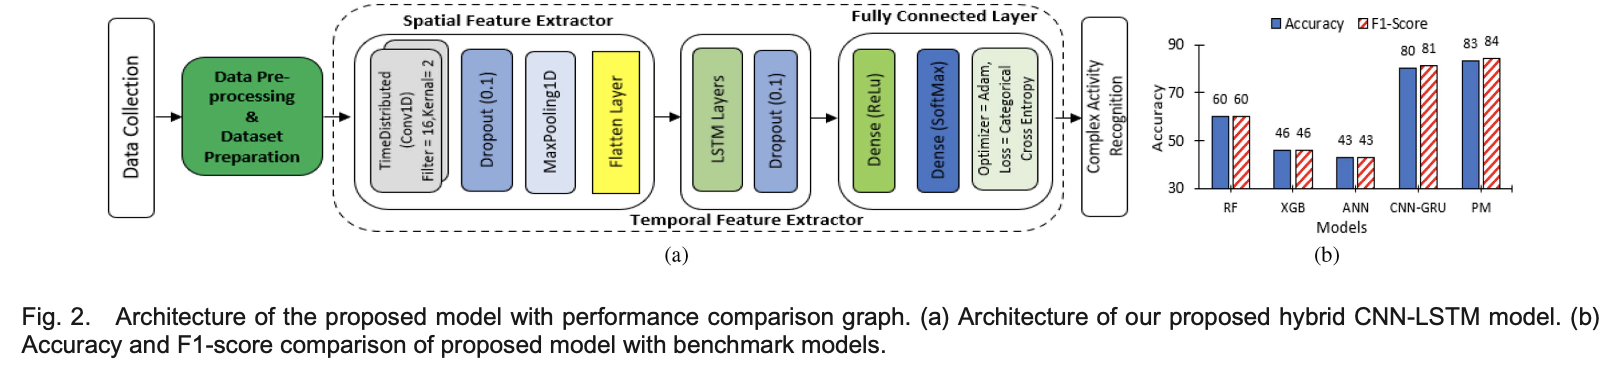


이 논문에서 저자는 1D-CNN으로 중요한 Feature을 추출하고 시간 데이터를 캡처하기 위하여 순환 신경망인 LSTM을 배치하였다. 


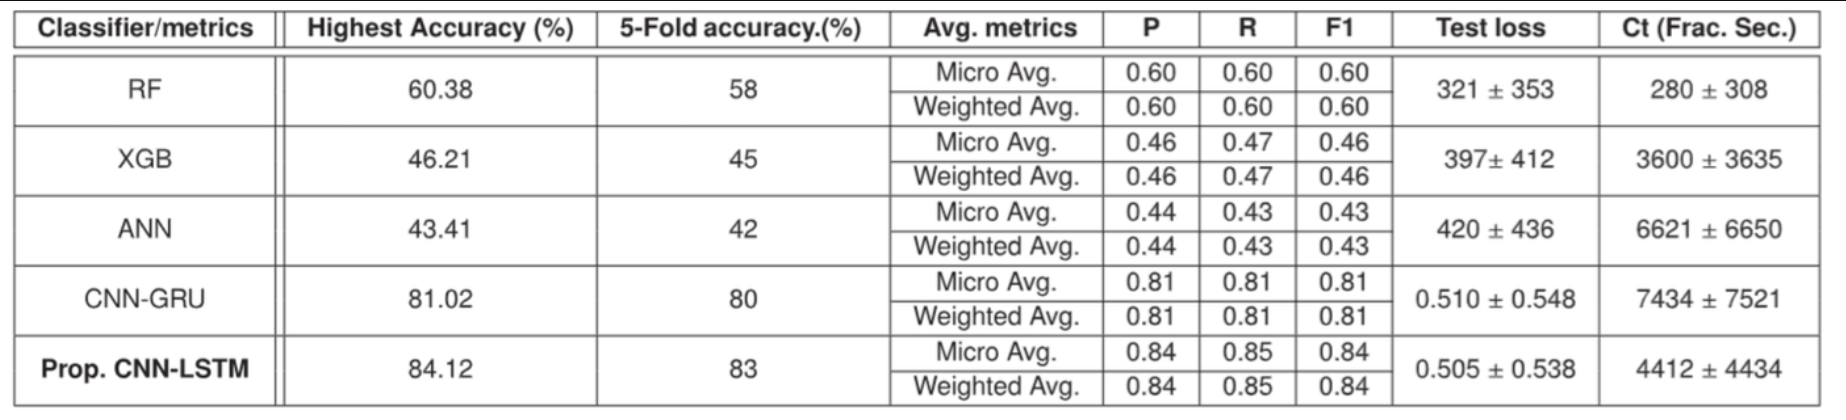

CNN-GRU, ANN과 같이 더욱 시간이 많이 걸리는 모델 대신 저자가 모델링한 CNN-LSTM이 시간 절약이 가능하며, 가장 높은 Accuracy와 낮은 test loss를 보여주고 있음을 위 figure에서 알 수 있다. CNN-LSTM 이외의 모델에서 발생한 문제점을 저자는 아래와 같이 언급하였다.

- 머신러닝 모델(RF 및 XGB)의 기능 부족과 직관으로 인해 모델은 확률 함수를 사용하여 복잡한 DLA를 인식해야 했음
- ANN은 기능 엔지니어링을 위한 컨볼루션 및 메모리 기능이 부족하고, 훈련 세트를 검증하는 동안 대부분의 성능을 잃기 때문에 공간적(예: 방향, 회전 속도, 최대 가속도 등) 및 시간적(예: 시간 경과에 따른 평균 가속도, 시간 경과에 따른 최대 방향 등) 기능을 캡처하지 못함
- CNN-GRU를 사용하여 시간 및 주파수 영역 기능을 획득했지만, 모델 훈련 중에 과적합되어 데이터 패턴을 최적으로 일반화하지 못함

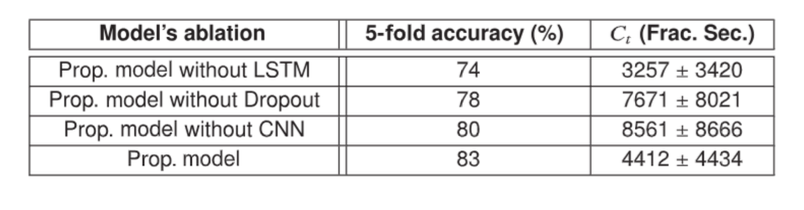

또한, CNN에 왜 LSTM을 붙여서 모델링하여야 하는지를 본 데이터가 time-series 데이터셋이라는 점을 강조하면서 설명하였다. 위 figure에서 나와있듯이, LSTM 레이어를 제거하면 정확도가 58%, 45%, 42% 및 80%의 평균 정확도로 제안된 모델보다 낮은 성능을 보였으며, 성능도가 74%로 크게 감소하여 기억 기능을 사용하여 시간적 종속성을 캡처하는 데 중요한 역할을 한다는 점을 강조하고 있다.


그러면 결국엔 아래와 같이 모델링하지 않았을까 예측할 수 있다.

- **각 피실험자마다 20개의 행동(normal 10개, aggressive 10개)을 classification하기 위해 종단 layer의 노드 수를 20, activation은 softmax**
    - 이 부분을 이렇게 변형할 수도 있다.
        - 이진 분류로, 10개의 기본 행동 dataset과 10개의 공격적 행동 dataset을 새로운 dataframe으로 만들어 inputing -> 이 행동이 기본 행동인가, 공격적 행동인가?
        - 다중 분류로, 4명의 dataset을 dataframe으로 전부 만들어서, 각 record는 사용자 번호로 labeling -> 이 근전기 수축량을 가진 참가자는 몇번인가?
- **위 figure 1을 보았을 때 Conv1D layer을 2개를 겹친 것을 보니 stacked CNN을 사용한듯 보임**

각 데이터 파일들에 대하여 아래와 같이 EDA를 실행하려고 한다.

- **(1) 각 데이터 파일들에 대하여 형태 조정 및 데이터 전처리**
    - 현재 데이터셋은 .rar으로 압축되어 있고, 압축을 풀면 각 사용자마다 측정한 데이터 폴더 (sub1, sub2, sub3, sub3)이 존재한다.
    - 각 폴더를 열면 'Normal', 'Aggressive' 폴더가 들어있고, 각 폴더에는 해당되는 행동의 수치를 txt로 저장하고 있다.
    - 자세한 구조는 이따 os 라이브러리의 내장 method를 통하여 디렉토리에 직접 접근한 후 파일을 열어 확인해보자.
- **(2) 기초통계량 파악 및 시각화를 통한 분포 확인**
    - 아래와 같이 시각화하여 분포를 확인해본다.
        - (1) 각 행동에 대하여 각 feature의 분포를 plot으로 확인
        - (2) 각 행동마다 heatmap 그려 상관관계 확인 
        - (3) countplot
- **(3) 필요 시 z-score normalization 진행**


------

### EDA 

아래와 같은 순서로 진행한다.

- **(1) 각 데이터 파일들에 대하여 형태 조정 및 데이터 전처리**
- **(2) 다양한 시각화를 통한 분포 확인 및 필요 시 z-score normalization**

#### (1) 각 데이터 파일들에 대하여 형태 조정 및 데이터 전처리

- 일단, 근전도 수치가 들어있는 dataset의 형태가 모두 txt이고 행동마다 모든 데이터가 독립적인 파일로 존재하기 때문에 하나로 병합하여 한 dataframe을 구축할 것이다.
- 파일을 열어 구조부터 확인하고, 구조 확인 후 병합하며, 병합이 완료되면 각 record마다 label을 붙인다.
    - 추후에 label encoding하지 않아도 되도록, 0-based로 target 나타낸다
- 병합할 때 각 열마다의 feature name은 각 데이터셋이 나타내는 행동으로 붙인다. 

In [117]:
# 현재 위치 디렉토리 이동 및 ls -lha로 현재 디렉토리 구조 확인

import os

os.system('cd ../../ && cd ./data/EMG/EMG && ls -lha && cd ./sub1 && ls -lha')

'''
    4명의 피실험자, 각 피실험자 폴더마다 Aggressive, Normal 폴더 있음
'''

total 16
drwxr-xr-x@ 7 alphastation  staff   224B  9 15 23:08 .
drwxr-xr-x  6 alphastation  staff   192B  9 15 23:08 ..
-rw-rw-r--@ 1 alphastation  staff   4.1K  9 12 15:25 readme.txt
drwxr-xr-x@ 4 alphastation  staff   128B  9 15 23:08 sub1
drwxr-xr-x@ 4 alphastation  staff   128B  9 15 23:08 sub2
drwxr-xr-x@ 4 alphastation  staff   128B  9 15 23:08 sub3
drwxr-xr-x@ 4 alphastation  staff   128B  9 15 23:08 sub4
total 0
drwxr-xr-x@ 4 alphastation  staff   128B  9 15 23:08 .
drwxr-xr-x@ 7 alphastation  staff   224B  9 15 23:08 ..
drwxr-xr-x@ 4 alphastation  staff   128B  9 15 23:08 Aggressive
drwxr-xr-x@ 4 alphastation  staff   128B  9 15 23:08 Normal


'\n    4명의 피실험자, 각 피실험자 폴더마다 Aggressive, Normal 폴더 있음\n'

In [118]:
# Aggressive와 Normal 각각에 있는 txt 파일 이름 확인

os.system('cd ../../ && cd ./data/EMG/EMG/sub1/Aggressive/txt && ls -lha')
os.system('cd ../../ && cd ./data/EMG/EMG/sub1/Normal/txt && ls -lha')

total 7536
drwxr-xr-x@ 12 alphastation  staff   384B  9 15 23:08 .
drwxr-xr-x@  4 alphastation  staff   128B  9 15 23:08 ..
-rw-rw-r--@  1 alphastation  staff   389K  9 12 15:25 Elbowing.txt
-rw-rw-r--@  1 alphastation  staff   381K  9 12 15:25 Frontkicking.txt
-rw-rw-r--@  1 alphastation  staff   393K  9 12 15:25 Hamering.txt
-rw-rw-r--@  1 alphastation  staff   342K  9 12 15:25 Headering.txt
-rw-rw-r--@  1 alphastation  staff   389K  9 12 15:25 Kneeing.txt
-rw-rw-r--@  1 alphastation  staff   379K  9 12 15:25 Pulling.txt
-rw-rw-r--@  1 alphastation  staff   371K  9 12 15:25 Punching.txt
-rw-rw-r--@  1 alphastation  staff   371K  9 12 15:25 Pushing.txt
-rw-rw-r--@  1 alphastation  staff   380K  9 12 15:25 Sidekicking.txt
-rw-rw-r--@  1 alphastation  staff   353K  9 12 15:25 Slapping.txt
total 6072
drwxr-xr-x@ 12 alphastation  staff   384B  9 15 23:08 .
drwxr-xr-x@  4 alphastation  staff   128B  9 15 23:08 ..
-rw-rw-r--@  1 alphastation  staff   305K  9 12 15:25 Bowing.txt
-rw-rw-r--@ 

0

In [119]:
# 위 파일 중 Normal/Running.txt 20줄만 출력

with open('../../data/EMG/EMG/sub1/Normal/txt/Running.txt', 'r') as file :
    for i, line in enumerate(file) :
        if i == 20 : # 20줄만 출력하기
            break
            
        print (line.strip())  

131	-91	2018	-75	4000	-4000	-1999	267
93	-233	2917	-78	4000	-4000	-2549	251
100	-369	3007	-84	4000	-4000	-4000	195
-108	-399	1770	-86	3232	-4000	-4000	186
-342	-192	815	-63	2759	-4000	-4000	140
-420	-4	-17	-22	2581	-4000	-4000	76
-473	40	-523	63	2386	-4000	-4000	154
-323	78	-317	124	1994	-4000	-4000	239
-91	139	-761	105	1669	-4000	-3637	241
107	56	-107	79	1971	-3848	-1684	296
334	0	2093	-105	2101	-3643	238	131
487	21	2095	-216	2101	-3405	1353	-450
537	-37	-146	-251	1850	-3144	2036	-909
281	-47	-1554	-359	420	-2895	2760	-1296
245	-55	-2241	-279	-1121	-2612	3754	-1709
277	8	-2318	-133	-2436	-2382	4000	-1831
102	98	-2497	-40	-4000	-2095	4000	-1911
-84	180	-2342	94	-4000	-1755	4000	-1820
-255	225	-1274	154	-3387	-1375	4000	-1204
-286	172	457	121	-1703	-875	4000	-419


각 폴더의 이름은 **행동**을 의미하며, 이때 각 파일에는 위와 같이 근전도 수치가 들어있다. 8개의 열로, 각각 아래와 같은 의미를 내포한다.

- R-Bic: 오른쪽 이두근 (C1)  
- R-Tri: 오른쪽 삼두근 (C2)  
- L-Bic: 왼쪽 이두근 (C3)  
- L-Tri: 왼쪽 삼두근 (C4)  
- R-Thi: 오른쪽 허벅지 (C5)  
- R-Ham: 오른쪽 햄스트링 (C6)  
- L-Thi: 왼쪽 허벅지 (C7)  
- L-Ham: 왼쪽 햄스트링 (C8)

따라서 일단은 각 행동별로 모든 수치 데이터 파일을 csv로 바꾼 후, 사용자별로 csv 파일을 만든다. 또한 각 행동별로의 dataframe을 병합할 때엔 행 기준으로 한다. 최종적으로 각 행동마다의 csv를 행 기준 병합으로 합쳐 총 $10000 \times 20 = 200000$개의 record를 가진 concatenate version을 만든다. (pandas 안에서 local로 병합한다.)

In [120]:
# 모든 파일을 csv로 변경 -> dataframe 만들기

import glob

# data dir
directory = '../../data/EMG/EMG'

behaviors = [
    # Aggressive
    "Elbowing",
    "Frontkicking",
    "Hamering",
    "Headering",
    "Kneeing",
    "Pulling",
    "Punching",
    "Pushing",
    "Sidekicking",
    "Slapping",
    
    # Normal
    "Bowing",
    "Clapping",
    "Handshaking",
    "Hugging",
    "Jumping",
    "Running",
    "Seating",
    "Standing",
    "Walking",
    "Waving"
]

# dataframe 넣을 directory
# 이중 directory 구조, 각 행동마다에 dataframe 넣을 것
dir_df = {}
for i in range (1, 5) :
    dir_compo = {}
    for behavior in behaviors : # 행동
        dir_compo[behavior] = None
    dir_df[f'sub{i}'] = dir_compo
    
print (dir_df)

txt_files = glob.glob(os.path.join(directory, '**', '*.txt'), 
                      recursive=True) # 하위 디렉토리까지 txt 파일 찾기

# readme_file = os.path.join(directory, 'readme.txt')
# txt_files = [file for file in txt_files if file != readme_file]

# header (feature의 이름들)
muscles = [
    "R-Bic",
    "R-Tri",
    "R-Thi",
    "R-Ham",
    "L-Bic",
    "L-Tri",
    "L-Thi",
    "L-Ham"
]

# txt -> csv
for i, txt_file in enumerate(txt_files) :
    try :
        with open(txt_file, 'r') as file :
            lines = file.readlines() # 파일 읽기

        csv_file = txt_file.replace('.txt', '.csv')

        with open(csv_file, 'w', encoding='utf-8') as file :
            for line in lines : # 라인마다
                csv_line = line.strip().replace('\t', ',')
                file.write(csv_line + '\n')

        os.remove(txt_file) # 원본 삭제
        
        print(f'{txt_file} -> {csv_file} : SUCCESS')
    
        df_temp = pd.read_csv(csv_file, names=muscles)
        print (df_temp.shape)
        
        # 피실험자 번호 찾기 -> directory에 데이터프레임 넣기
        for j in range(1, 5) :
            if str(j) in csv_file :
                for behavior in behaviors :
                    if behavior in csv_file :
                        dir_df[f'sub{j}'][behavior] = df_temp
                        break
        
    except Exception as e :
        print(f"{e}")
        
    print ('\n---------------------\n')

print (dir_df)

{'sub1': {'Elbowing': None, 'Frontkicking': None, 'Hamering': None, 'Headering': None, 'Kneeing': None, 'Pulling': None, 'Punching': None, 'Pushing': None, 'Sidekicking': None, 'Slapping': None, 'Bowing': None, 'Clapping': None, 'Handshaking': None, 'Hugging': None, 'Jumping': None, 'Running': None, 'Seating': None, 'Standing': None, 'Walking': None, 'Waving': None}, 'sub2': {'Elbowing': None, 'Frontkicking': None, 'Hamering': None, 'Headering': None, 'Kneeing': None, 'Pulling': None, 'Punching': None, 'Pushing': None, 'Sidekicking': None, 'Slapping': None, 'Bowing': None, 'Clapping': None, 'Handshaking': None, 'Hugging': None, 'Jumping': None, 'Running': None, 'Seating': None, 'Standing': None, 'Walking': None, 'Waving': None}, 'sub3': {'Elbowing': None, 'Frontkicking': None, 'Hamering': None, 'Headering': None, 'Kneeing': None, 'Pulling': None, 'Punching': None, 'Pushing': None, 'Sidekicking': None, 'Slapping': None, 'Bowing': None, 'Clapping': None, 'Handshaking': None, 'Hugging': N

../../data/EMG/EMG/sub3/Aggressive/txt/Slapping.txt -> ../../data/EMG/EMG/sub3/Aggressive/txt/Slapping.csv : SUCCESS
(10173, 8)

---------------------

../../data/EMG/EMG/sub3/Aggressive/txt/Kneeing.txt -> ../../data/EMG/EMG/sub3/Aggressive/txt/Kneeing.csv : SUCCESS
(9205, 8)

---------------------

../../data/EMG/EMG/sub3/Aggressive/txt/Punching.txt -> ../../data/EMG/EMG/sub3/Aggressive/txt/Punching.csv : SUCCESS
(9994, 8)

---------------------

../../data/EMG/EMG/sub3/Aggressive/txt/Sidekicking.txt -> ../../data/EMG/EMG/sub3/Aggressive/txt/Sidekicking.csv : SUCCESS
(10024, 8)

---------------------

../../data/EMG/EMG/sub3/Aggressive/txt/Headering.txt -> ../../data/EMG/EMG/sub3/Aggressive/txt/Headering.csv : SUCCESS
(10098, 8)

---------------------

../../data/EMG/EMG/sub3/Normal/txt/Standing.txt -> ../../data/EMG/EMG/sub3/Normal/txt/Standing.csv : SUCCESS
(9604, 8)

---------------------

../../data/EMG/EMG/sub3/Normal/txt/Waving.txt -> ../../data/EMG/EMG/sub3/Normal/txt/Waving.cs

위 dir_df를 확인하였을 때, 각자에 맞는 dataframe이 component로 들어가 있는 것을 확인 가능하다. 각 행동 dataframe의 결측치를 제거하고, target 열을 행동의 이름으로 추가해야 한다. 이때, 각 행동별로 0-based의 숫자를 매겨 추후 label encoding을 할 필요 없게끔 한다. 각 행동별로 숫자는 아래와 같다.

```python
behaviors = [
    # Aggressive
    "Elbowing",      # -> 0
    "Frontkicking",  # -> 1
    "Hamering",      # -> 2
    "Headering",     # -> 3
    "Kneeing",       # -> 4
    "Pulling",       # -> 5
    "Punching",      # -> 6
    "Pushing",       # -> 7
    "Sidekicking",   # -> 8
    "Slapping",      # -> 9
    
    # Normal
    "Bowing",        # -> 10
    "Clapping",      # -> 11
    "Handshaking",   # -> 12
    "Hugging",       # -> 13
    "Jumping",       # -> 14
    "Running",       # -> 15
    "Seating",       # -> 16
    "Standing",      # -> 17
    "Walking",       # -> 18
    "Waving"         # -> 19
]
```

In [121]:
# 모든 파일을 열어서 target 열 추가

behavior_to_index = {
    "Elbowing": 0,
    "Frontkicking": 1,
    "Hamering": 2,
    "Headering": 3,
    "Kneeing": 4,
    "Pulling": 5,
    "Punching": 6,
    "Pushing": 7,
    "Sidekicking": 8,
    "Slapping": 9,
    "Bowing": 10,
    "Clapping": 11,
    "Handshaking": 12,
    "Hugging": 13,
    "Jumping": 14,
    "Running": 15,
    "Seating": 16,
    "Standing": 17,
    "Walking": 18,
    "Waving": 19
}


for key_1 in dir_df.keys() : 
    for key_2 in dir_df[key_1].keys() : 
        dir_df[key_1][key_2]['target'] = behavior_to_index[key_2]

In [122]:
# 모든 파일의 결측치 전처리 (결측치를 평균값으로 대체)

for key_1 in dir_df.keys() : 
    for key_2 in dir_df[key_1].keys() : 
        print (dir_df[key_1][key_2].isnull().sum())
        dir_df[key_1][key_2] = dir_df[key_1][key_2].fillna(dir_df[key_1][key_2].mean())

R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi   

In [123]:
# sample로 head : dir_df['sub1']['Seating']

dir_df['sub1']['Elbowing'].head()

R-Bic  R-Tri  R-Thi  R-Ham  L-Bic  L-Tri  L-Thi  L-Ham  target
0   -245    266   2615    -29  -4000   -549  -4000   4000       0
1   -814    391    -22   -277  -4000   -130  -4000   4000       0
2   -445    257  -3628   -428  -4000     97  -4000   4000       0
3   -844    201  -4000   -498  -4000     62  -4000   4000       0
4  -1996    233  -4000   -552  -4000    109  -4000   4000       0

- **```CAUTION!``` : 데이터가 너무 많은 관계로, 추후 학습 및 EDA 과정에서는 'sub1'의 데이터만 사용한다.**

#### (2) 다양한 시각화를 통한 분포 확인 및 필요 시 z-score normalization

아래와 같이 시각화하여 분포를 확인해본다.

- (1) 각 행동에 대하여 각 feature의 분포를 plot으로 확인
- (2) 각 행동마다 heatmap 그려 상관관계 확인

##### (2-1) 각 행동에 대하여 각 feature의 분포를 plot으로 확인

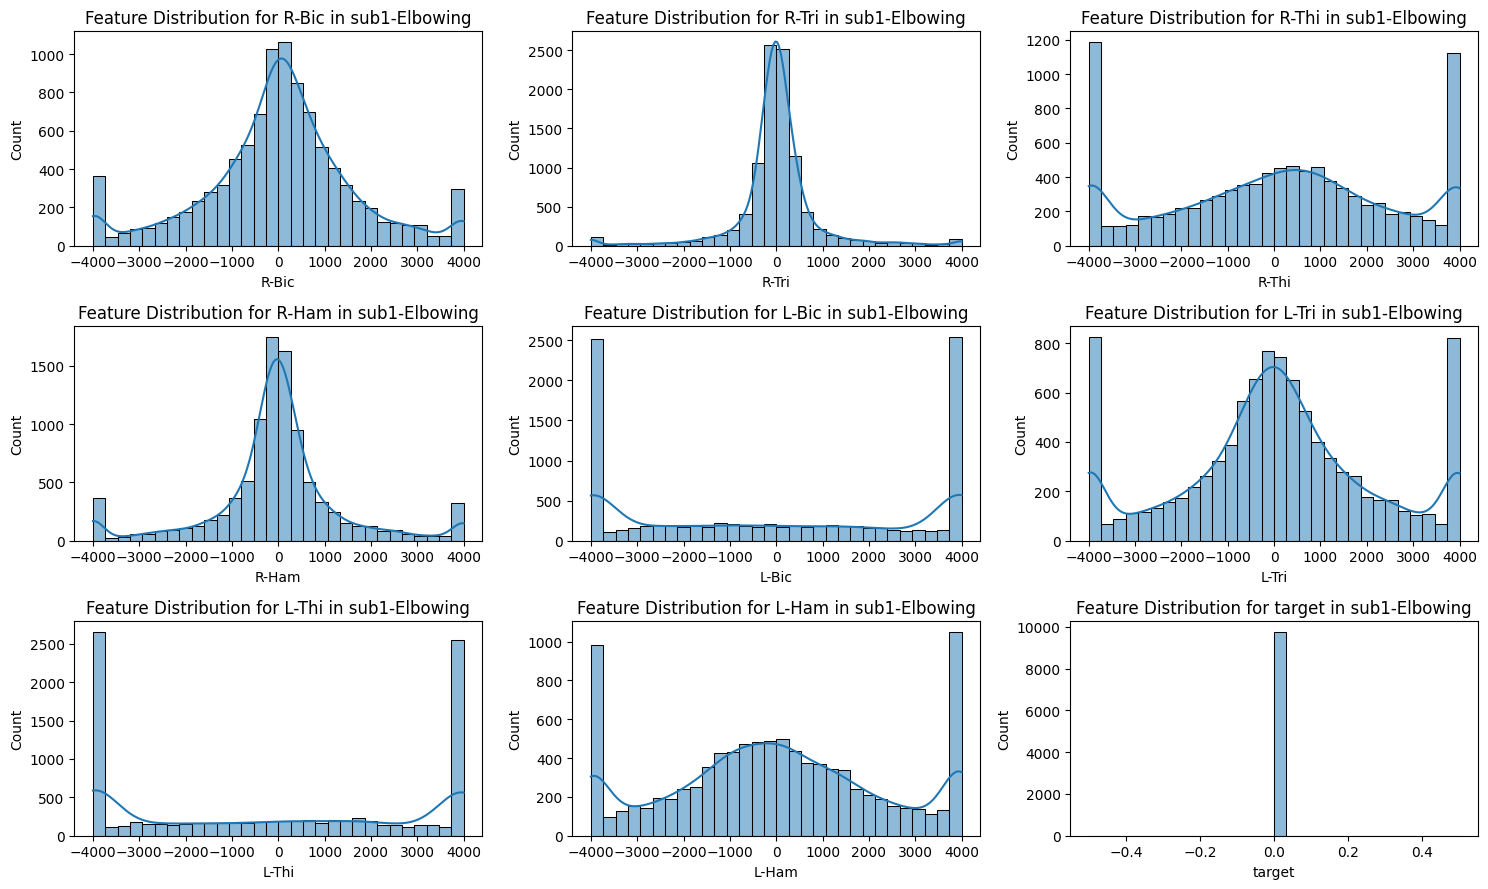


-----------------------



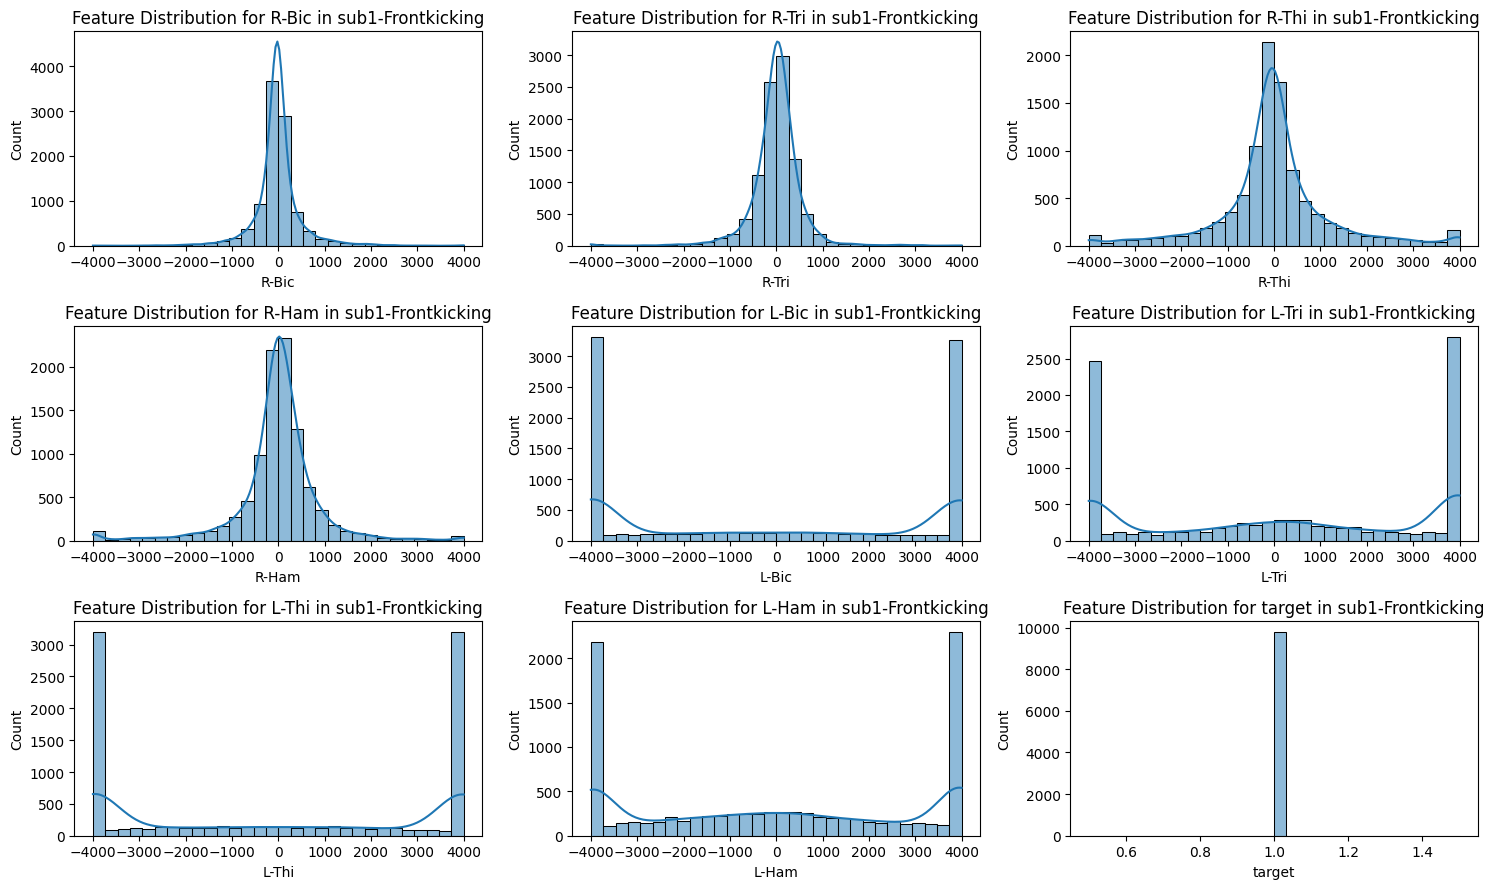


-----------------------



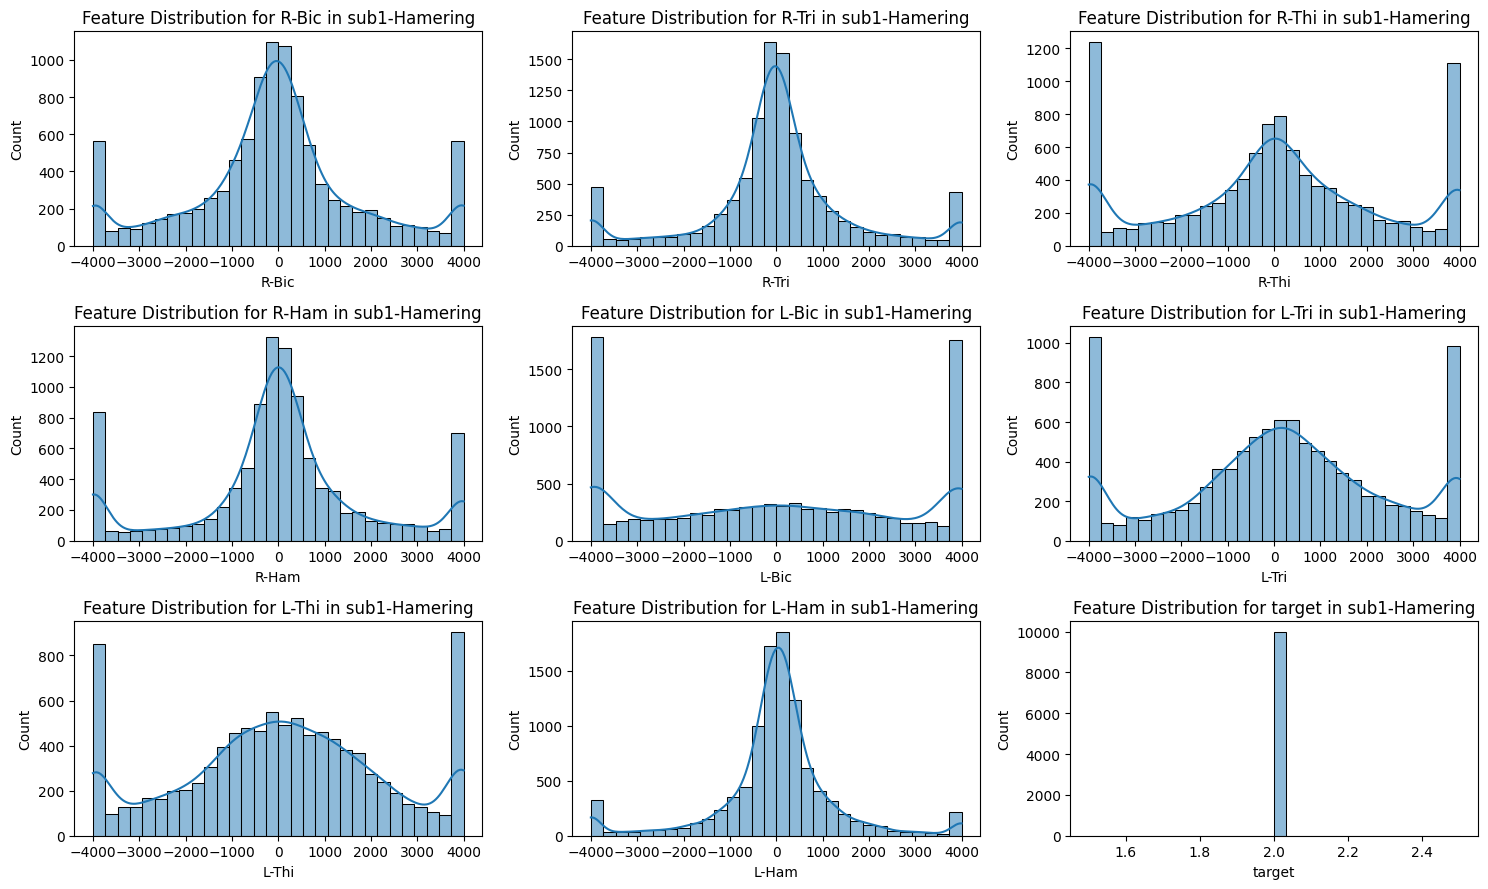


-----------------------



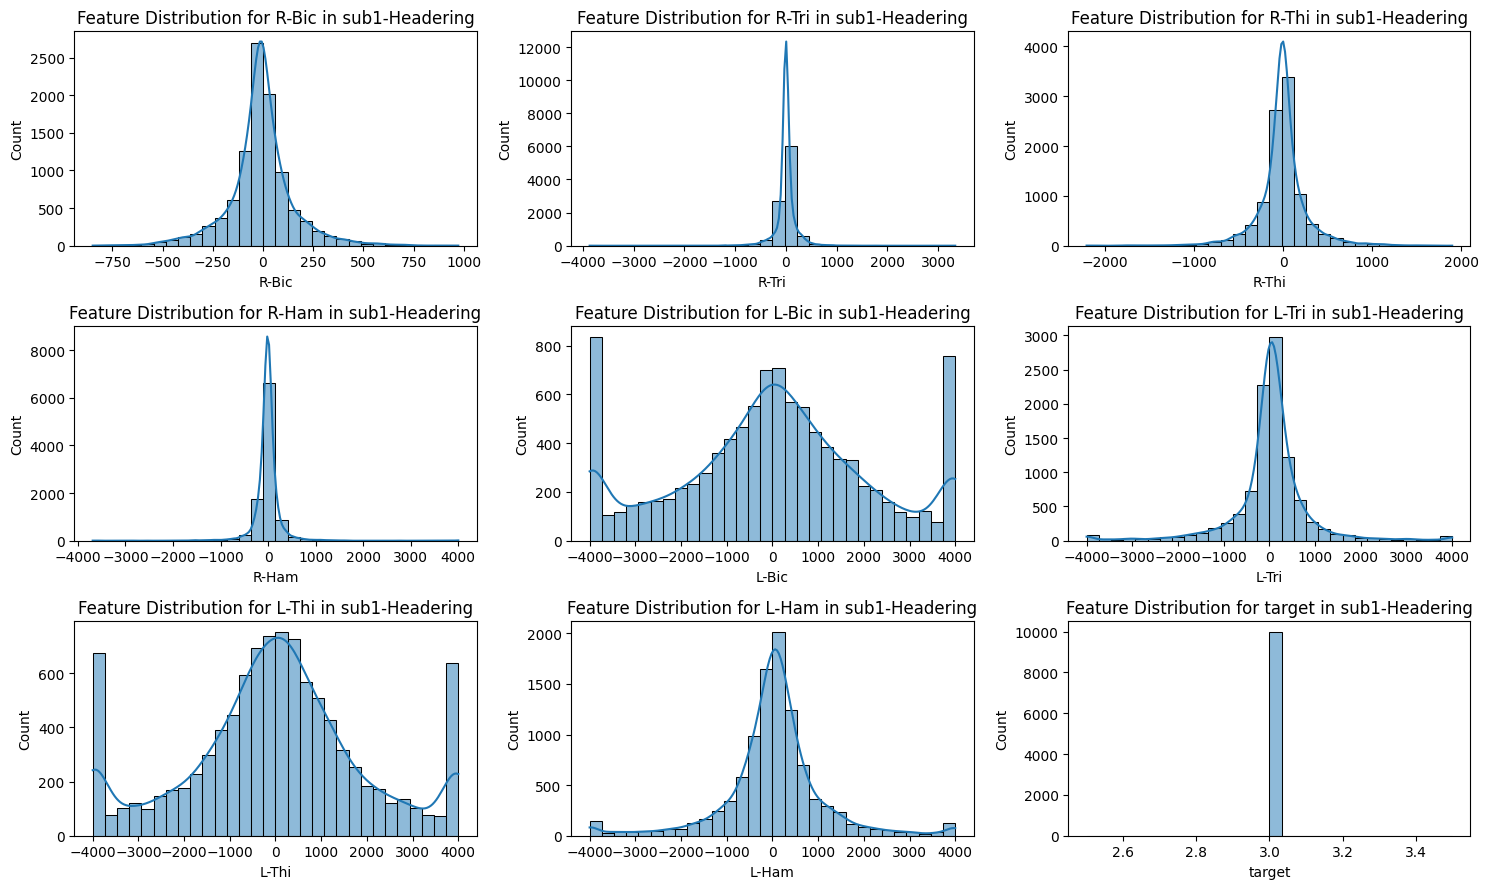


-----------------------



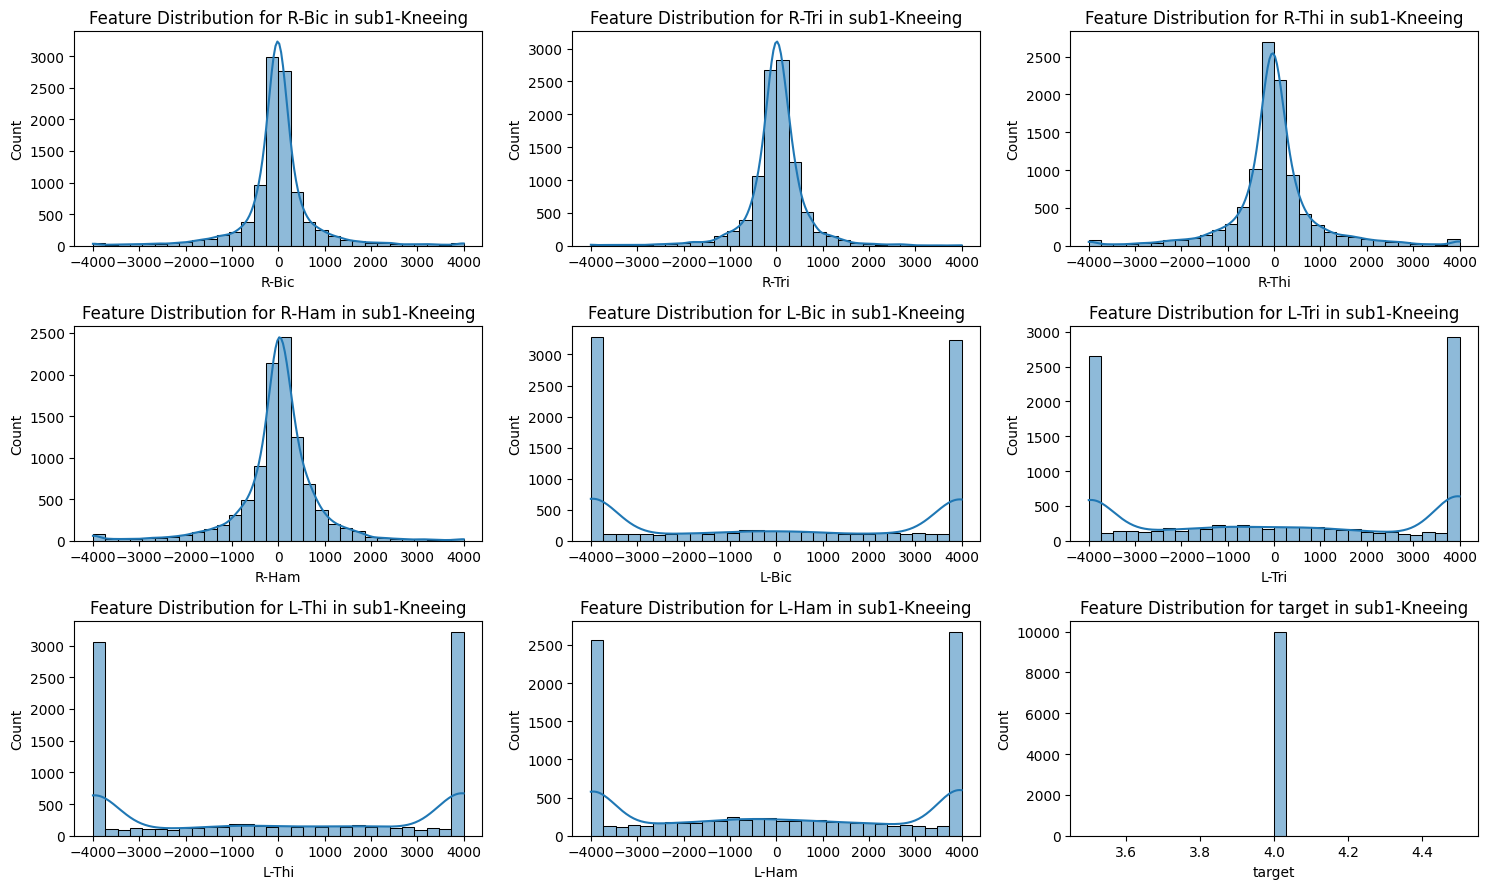


-----------------------



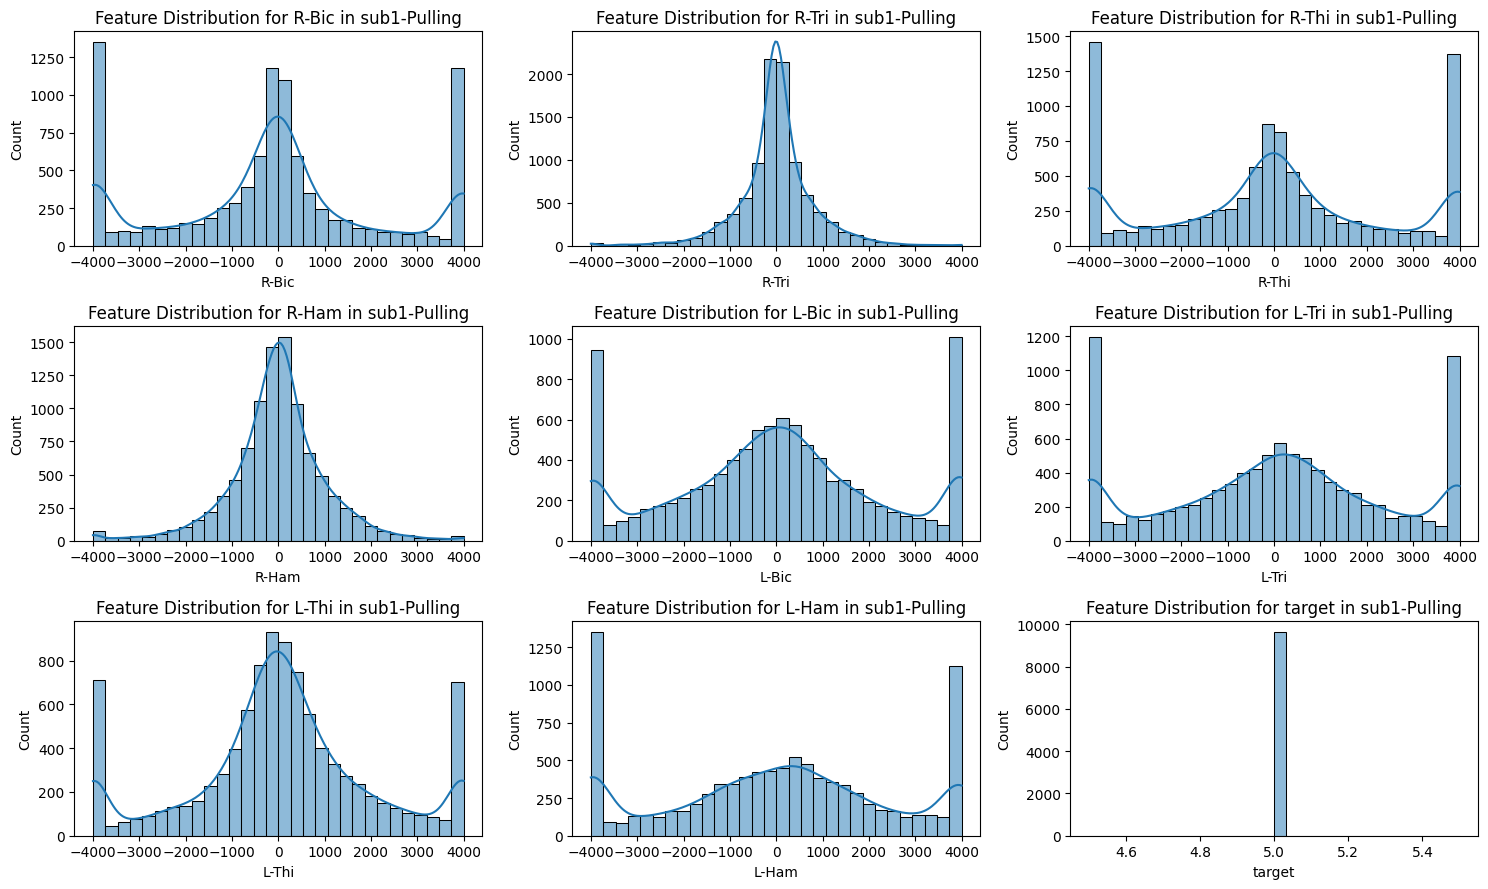


-----------------------



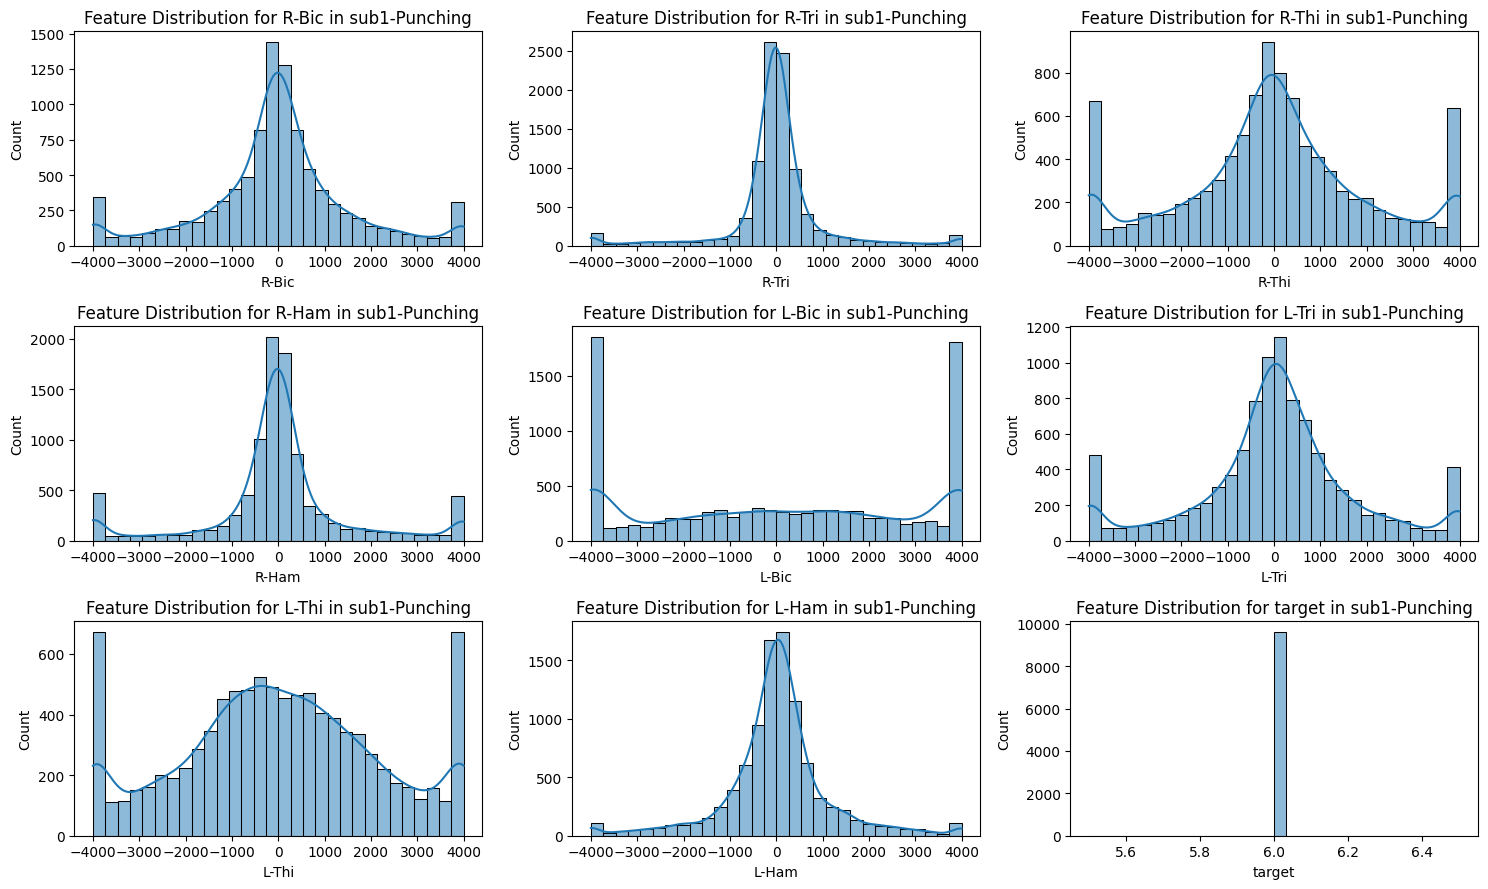


-----------------------



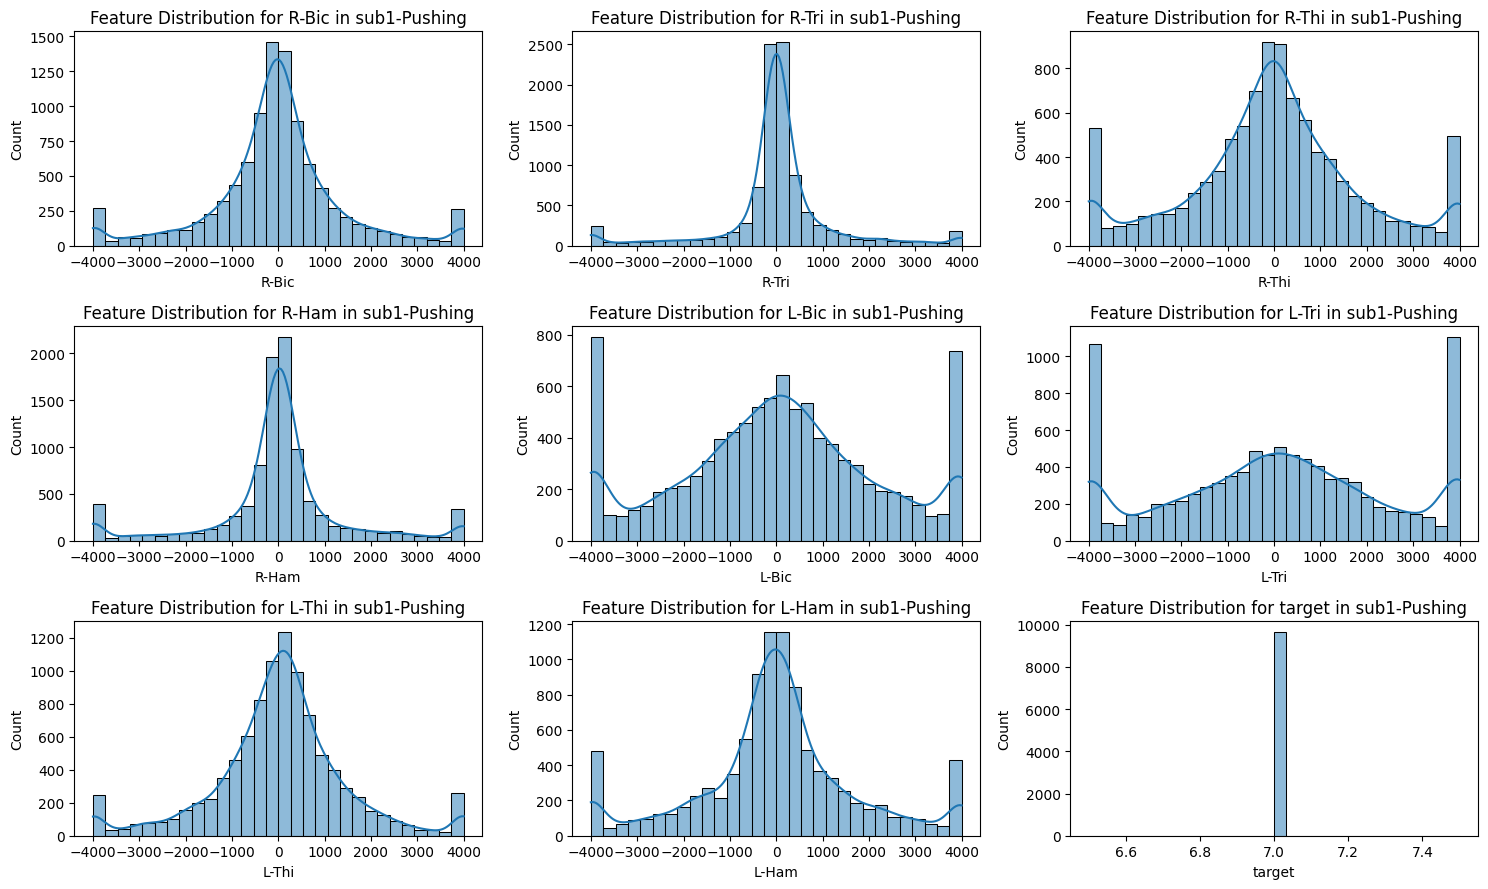


-----------------------



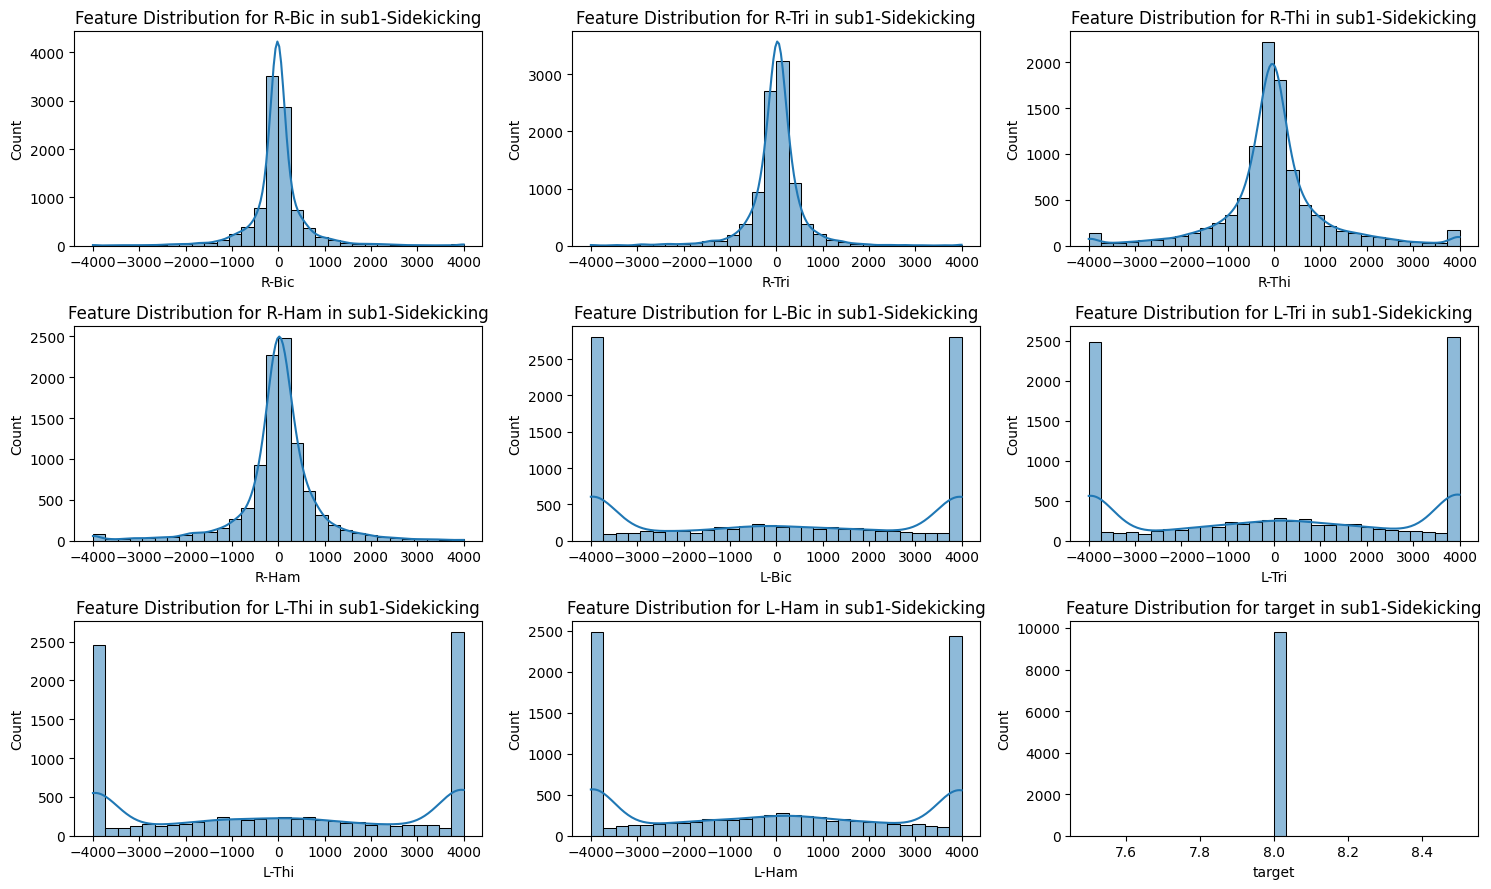


-----------------------



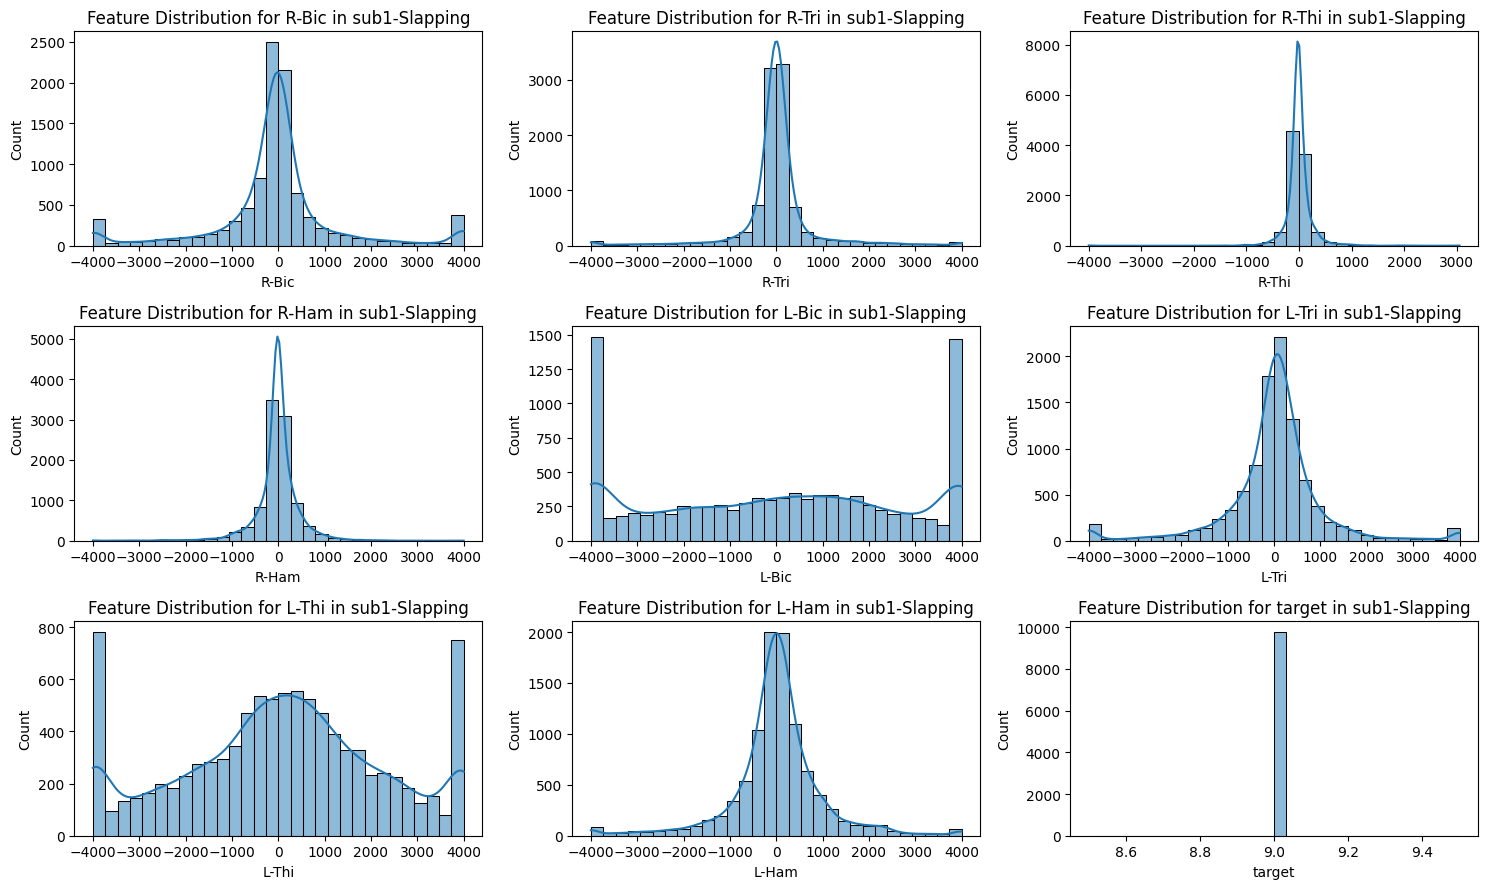


-----------------------



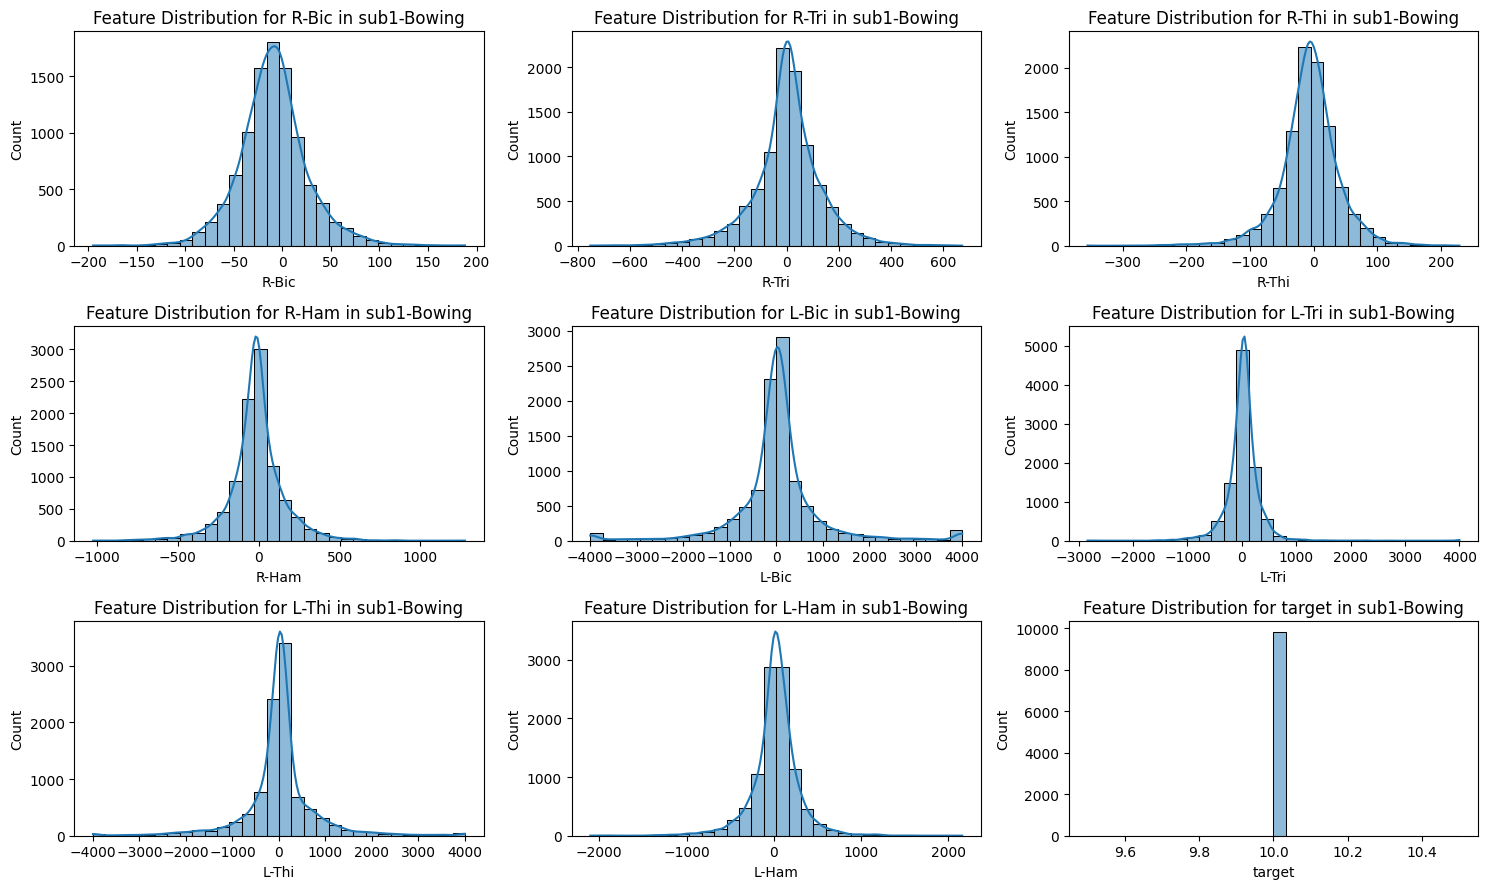


-----------------------



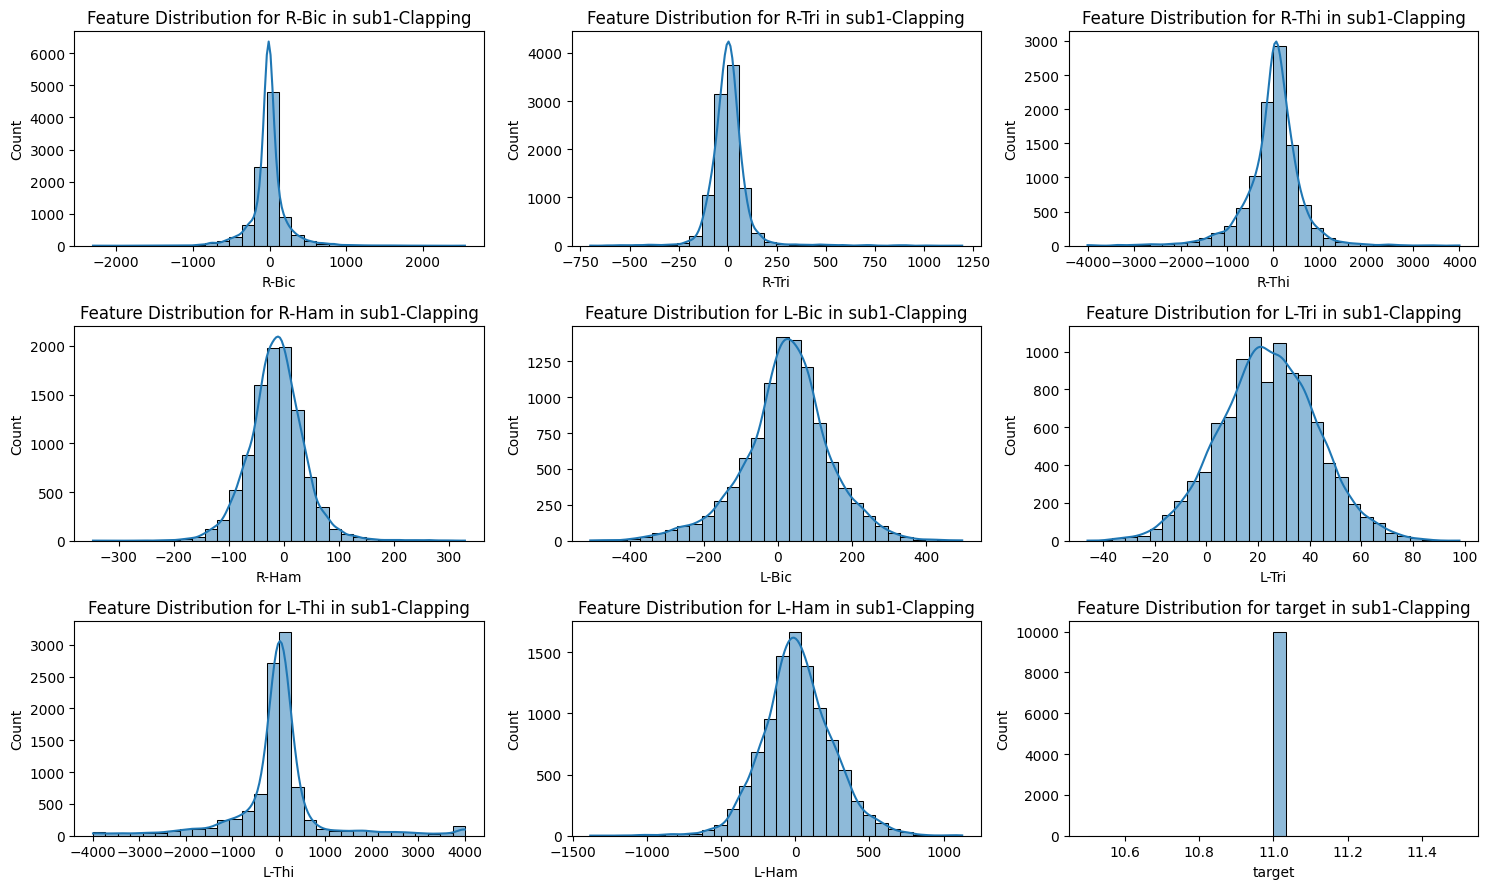


-----------------------



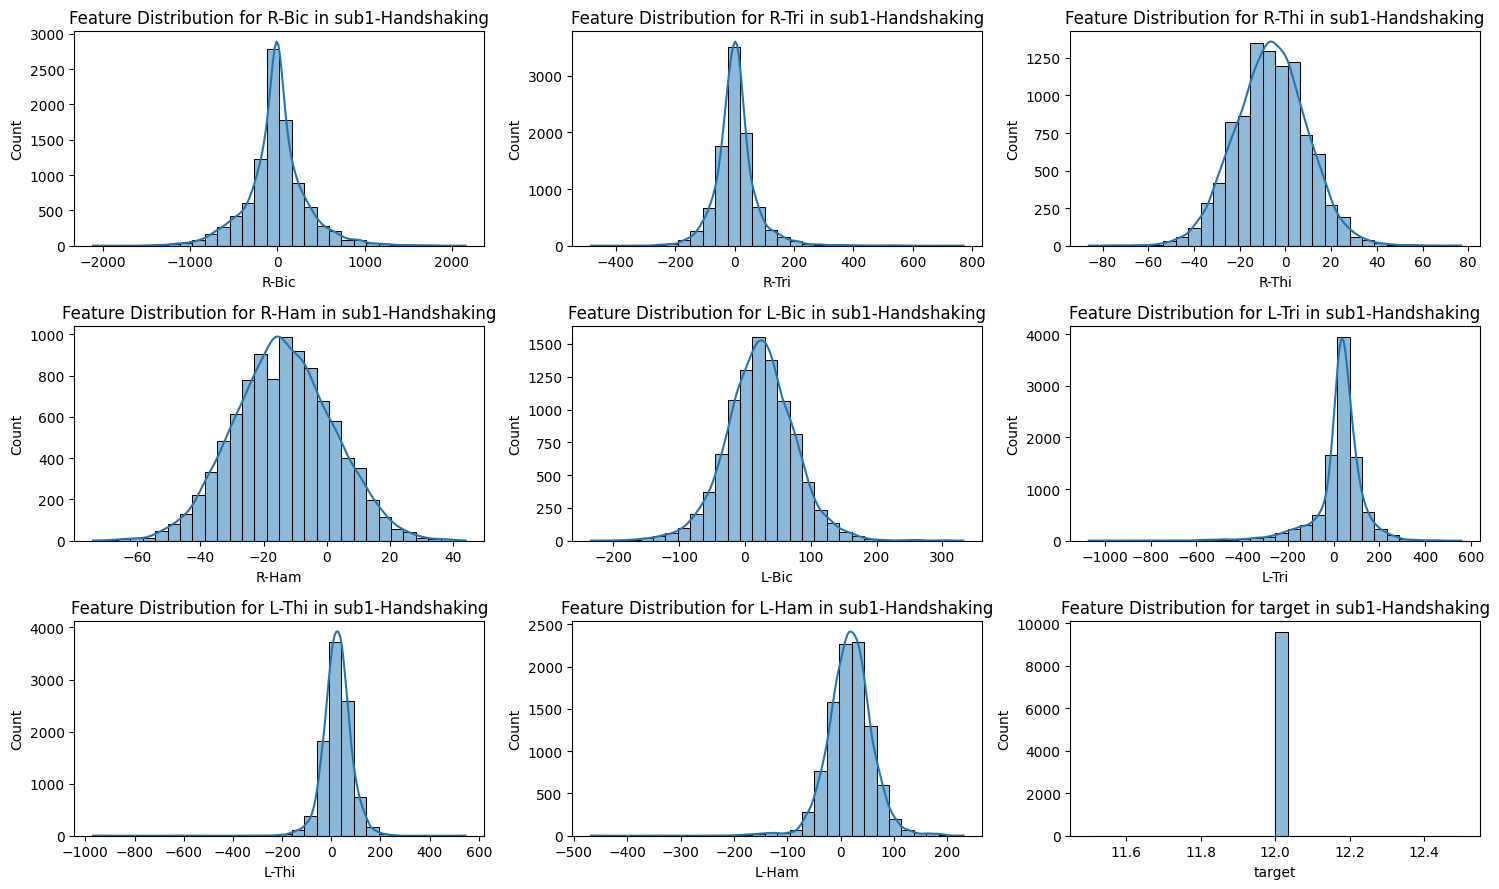


-----------------------



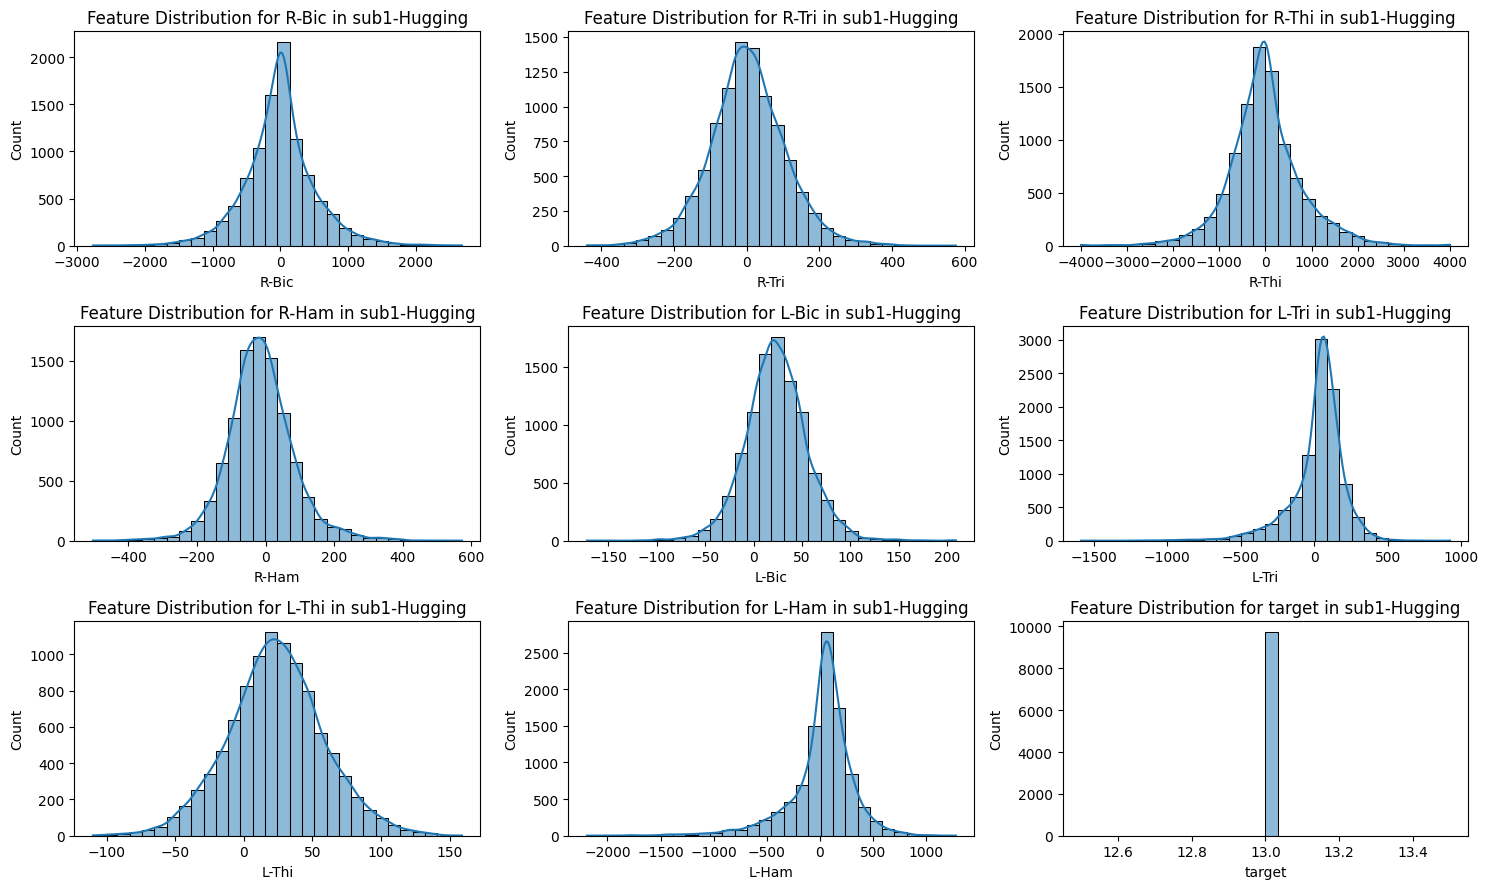


-----------------------



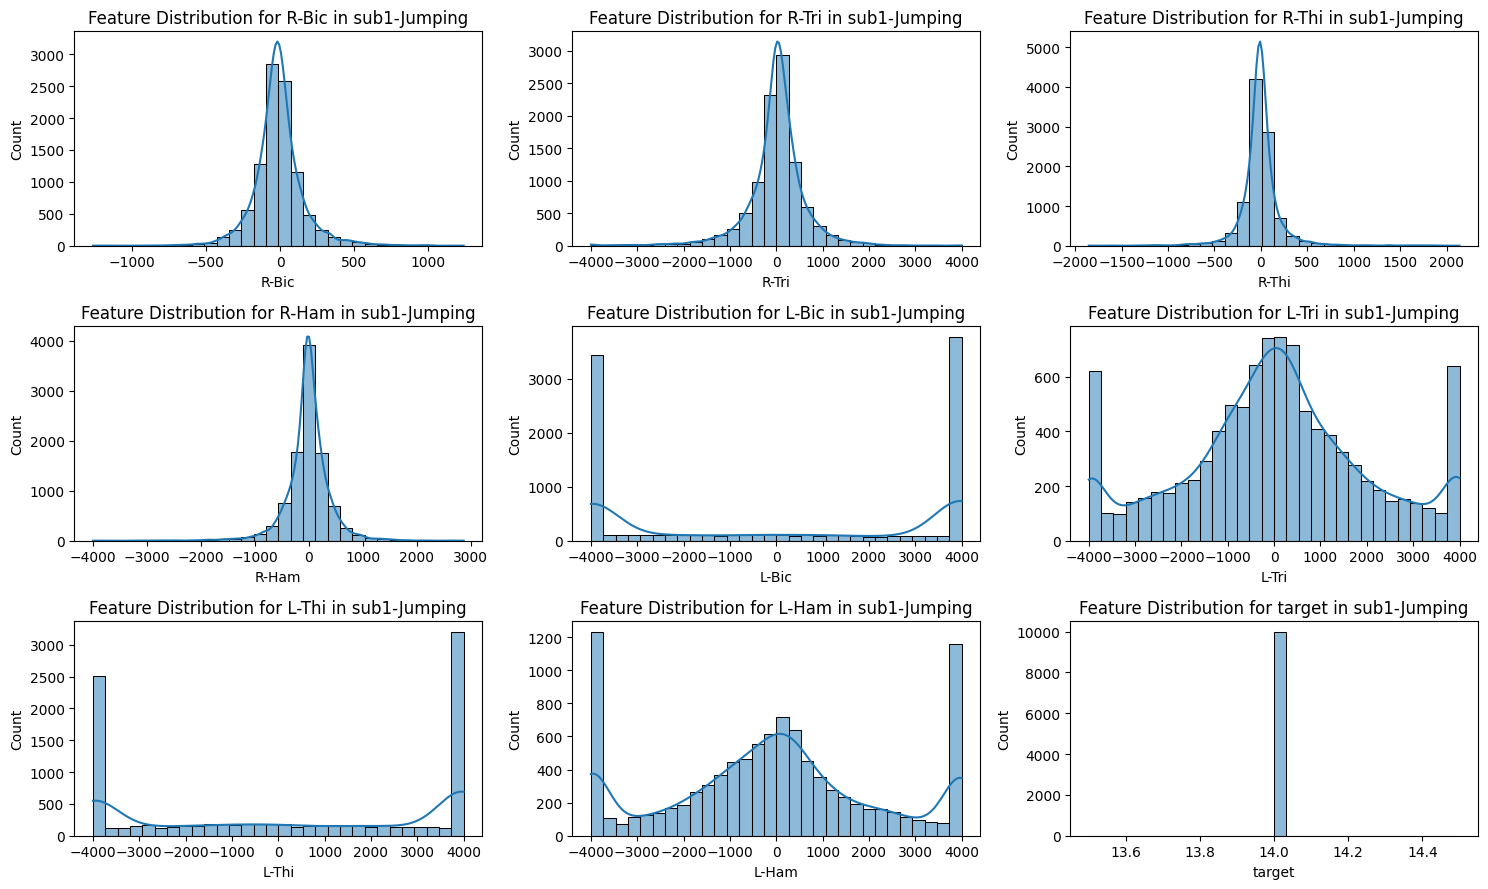


-----------------------



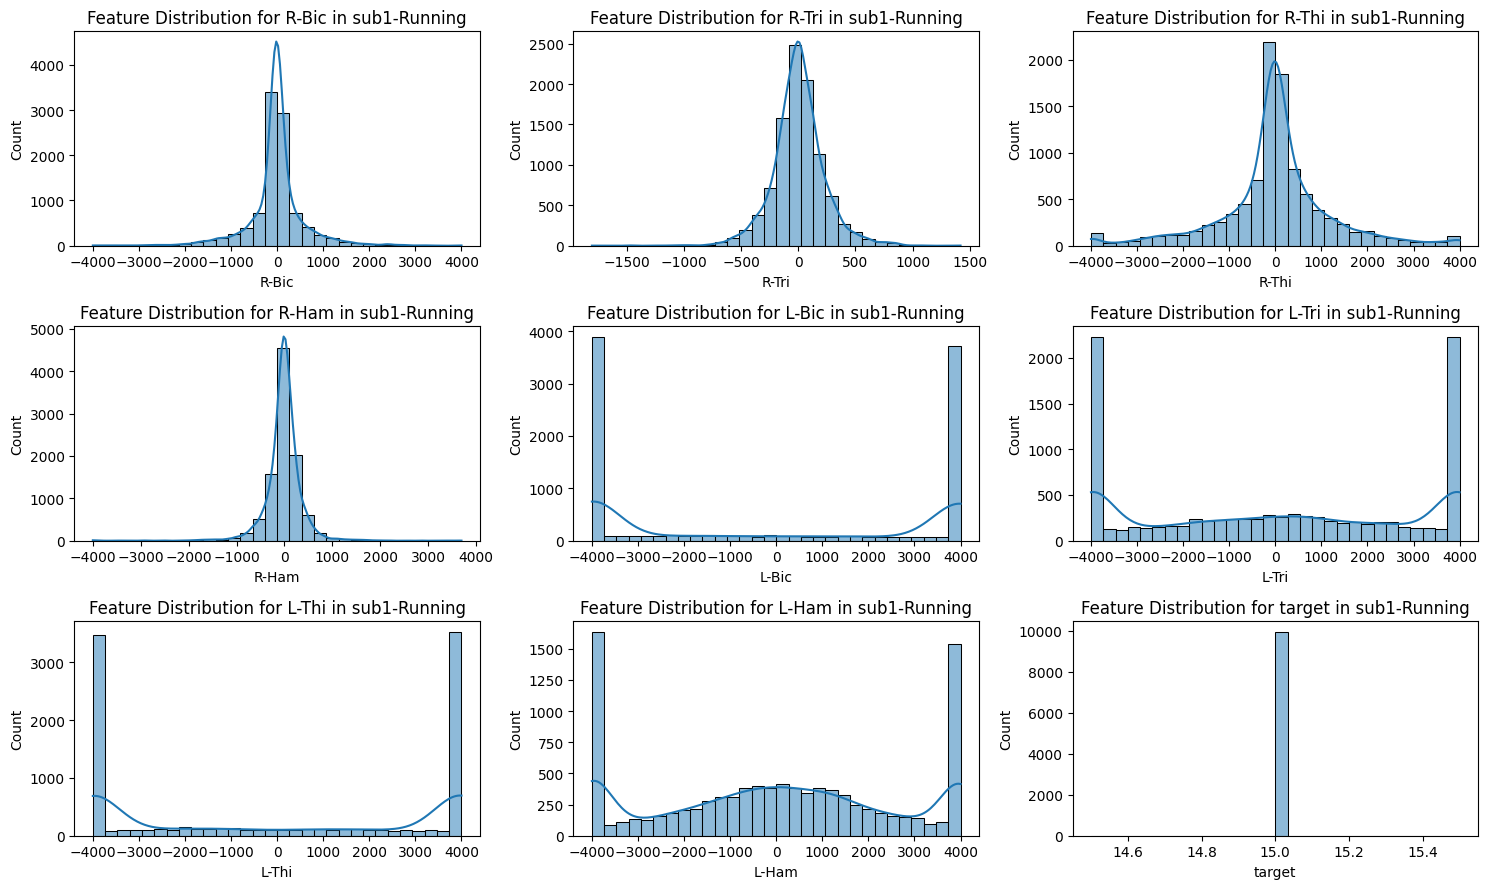


-----------------------



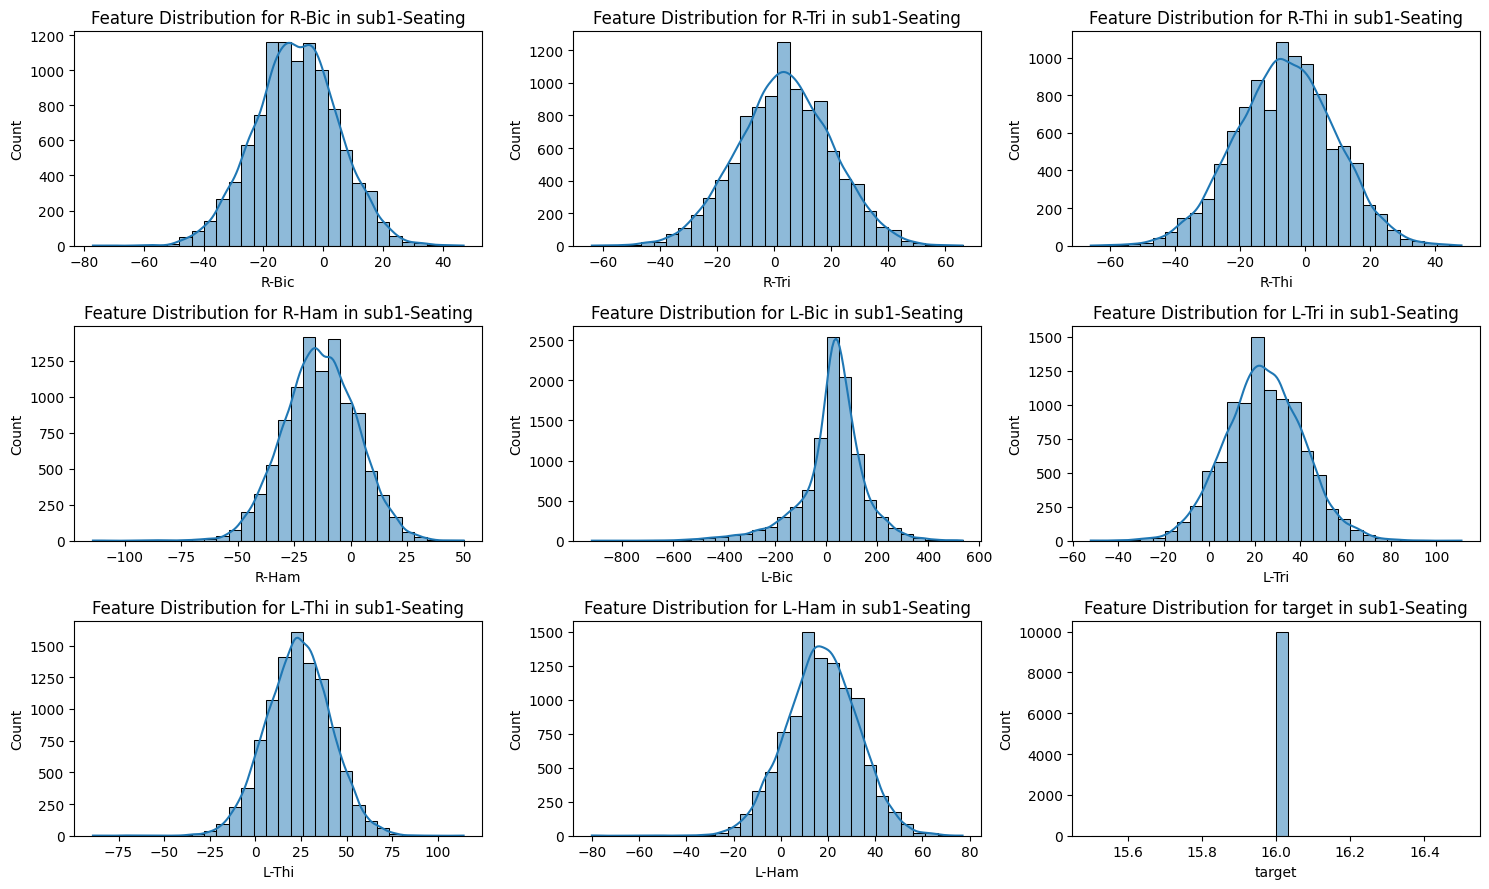


-----------------------



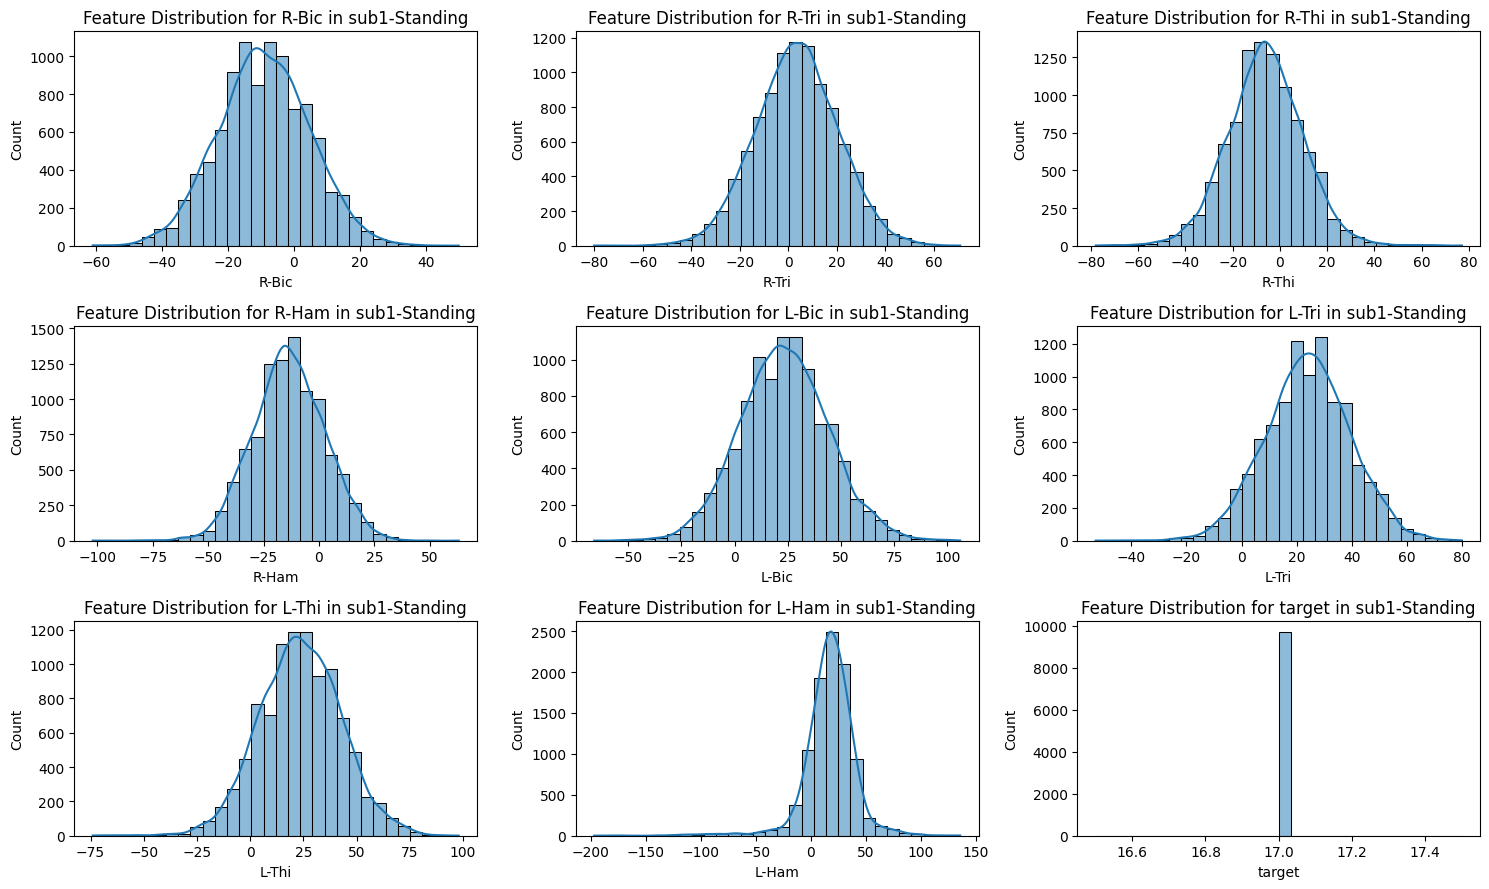


-----------------------



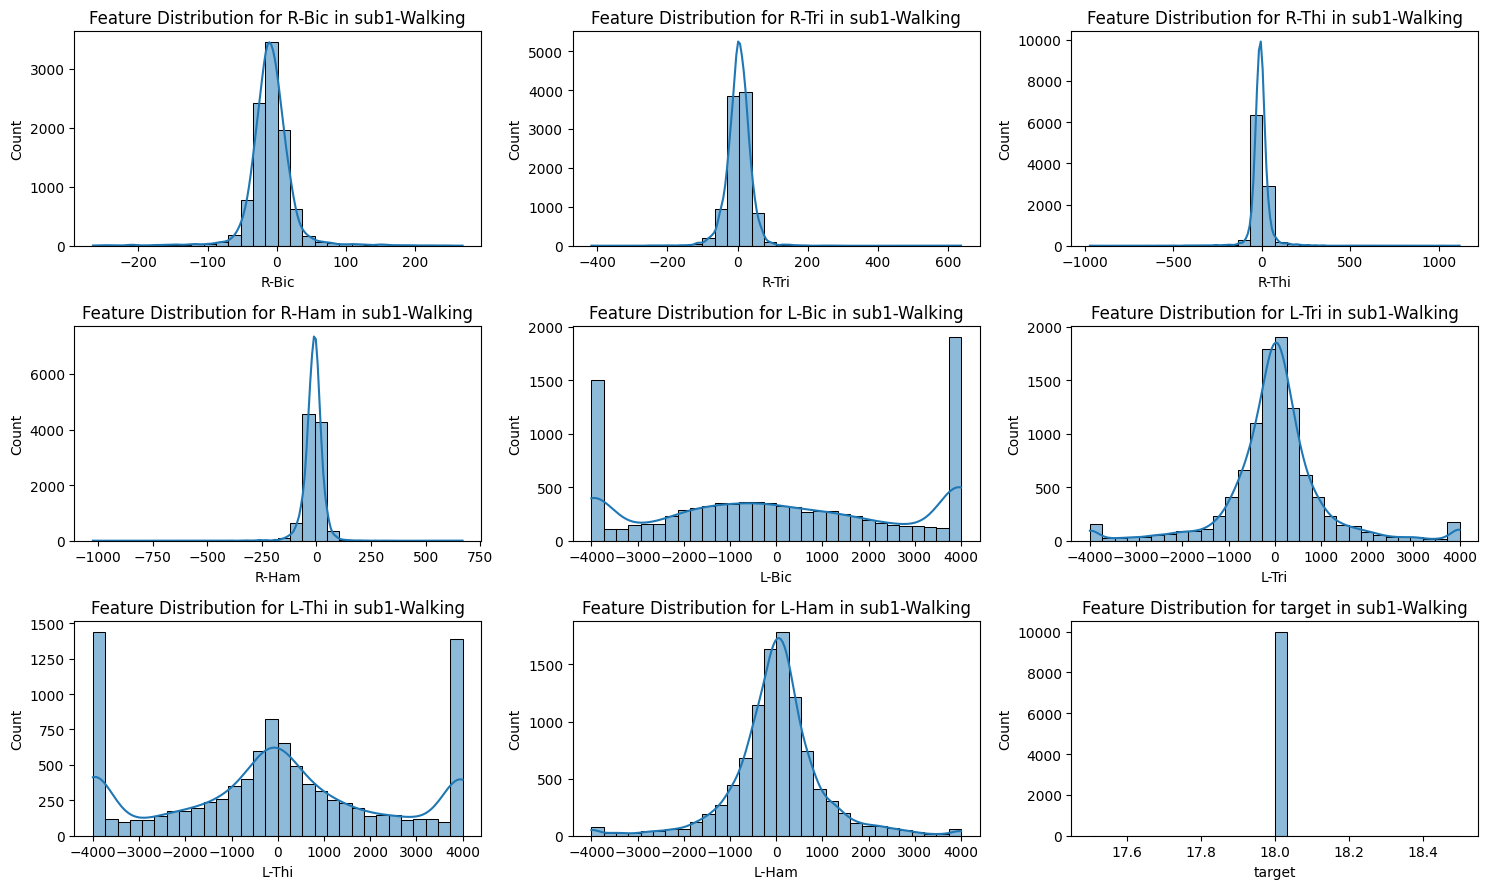


-----------------------



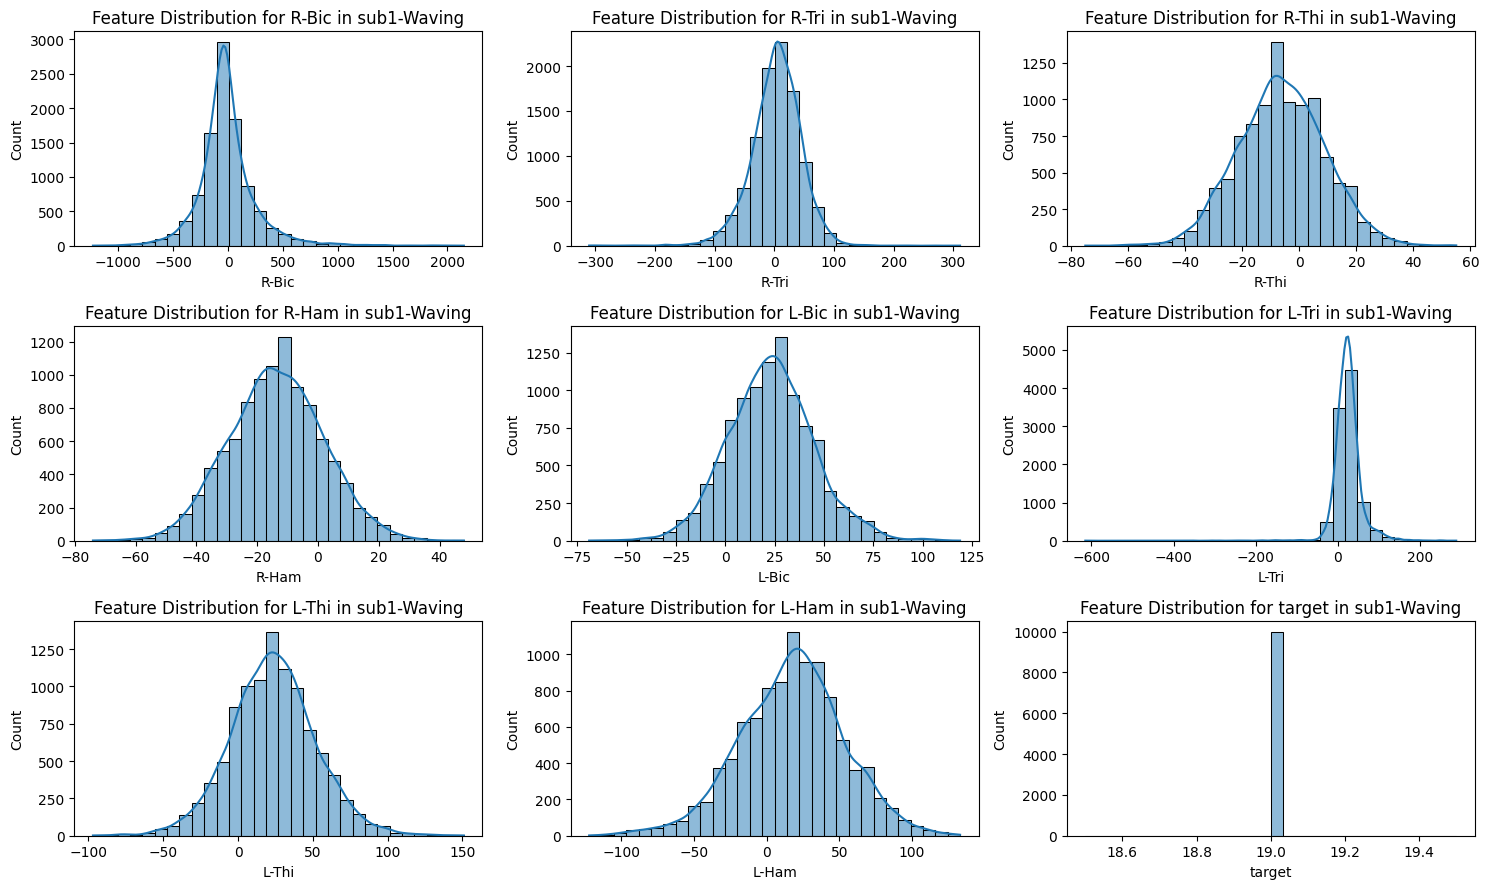


-----------------------



In [124]:
# 각 행동마다 feature 분포를 plot으로 확인

import matplotlib.pyplot as plt
import seaborn as sns
import math

for key_2 in dir_df['sub1'].keys() : 
    df = dir_df['sub1'][key_2] # 행동별 df에 접근

    num_features = len(df.columns) # feature 갯수 필요
    num_cols = 3   # 세로
    num_rows = math.ceil(num_features / num_cols) # 가로

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten() 

    for i, col in enumerate(df.columns) : # 각 col별로 그림 그리기
        if df[col].dtype != 'object' : # 만약 연속형이면 hist
            sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
            axes[i].set_title(f'Feature Distribution for {col} in sub1-{key_2}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            
        else : # 범주형이면 count
            sns.countplot(x=col, data=df, ax=axes[i])
            axes[i].set_title(f'Feature Distribution for {col} in sub1-{key_2}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')

    for j in range(i + 1, num_rows * num_cols) :
        fig.delaxes(axes[j]) # 빈 figure는 없애기

    plt.tight_layout()
    plt.show()
    
    print ('\n-----------------------\n')


위 figure을 보았을 때, 아래와 같이 생각할 수 있다.

- **굳이 z-score normalization을 할 필요가 전혀 없어보인다.** 각 feature의 분포가 아주 적절히 정규분포를 띄고 있음을 파악 가능하다.
- **매우 흥미로운 건, Kneeing이나 Elbowing 등 특정 행동에서는 L와 R 하나가 매우 낮은 수치를 보이는 fig가 있다는 것이다.**
    - 예측하건데, 피실험자 sub1가 공격적인 행동을 할 때 **한 팔로만 공격**하는 것 같다.

##### (2-2) 각 행동마다 heatmap 그려 상관관계 확인

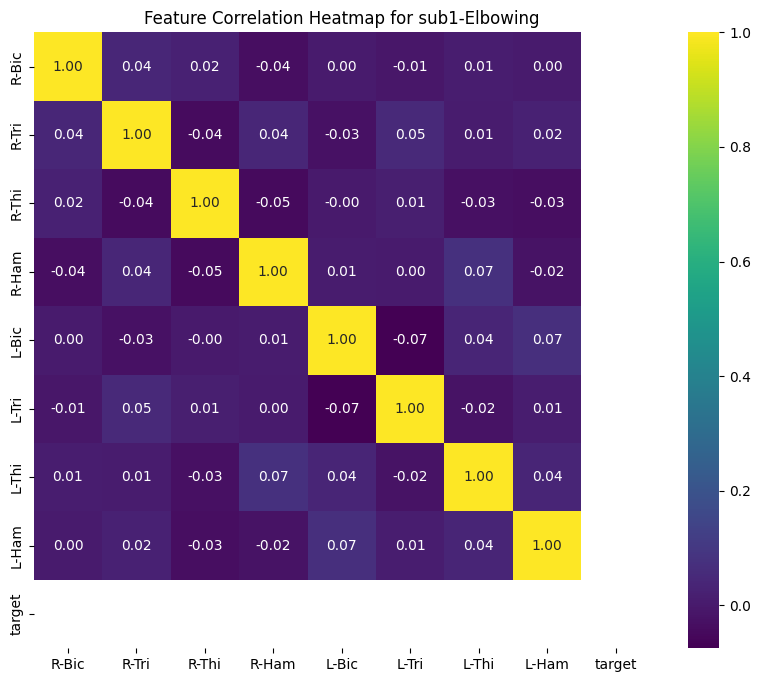

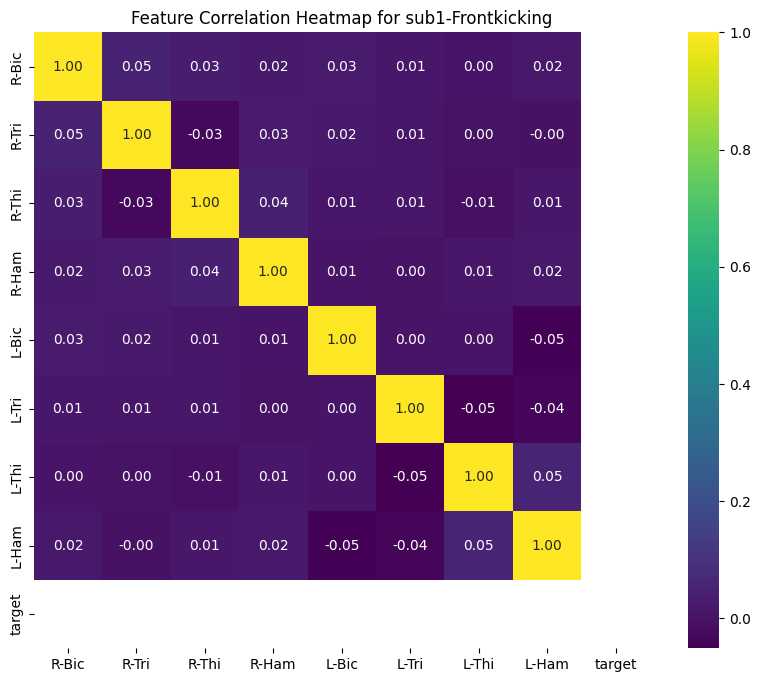

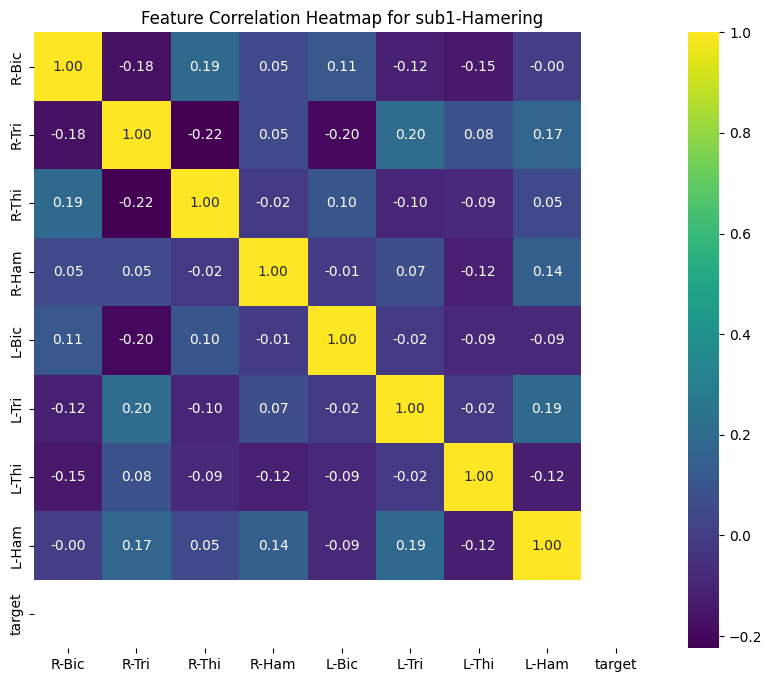

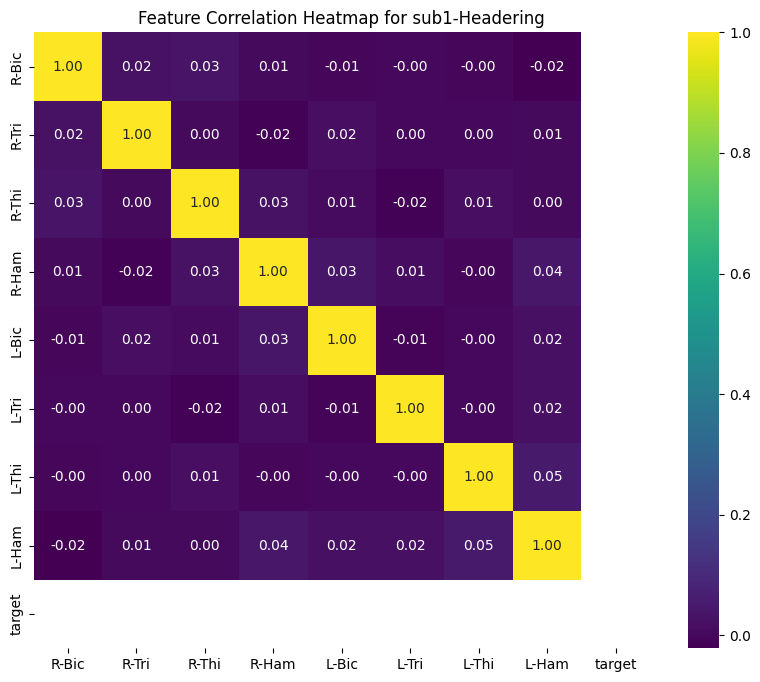

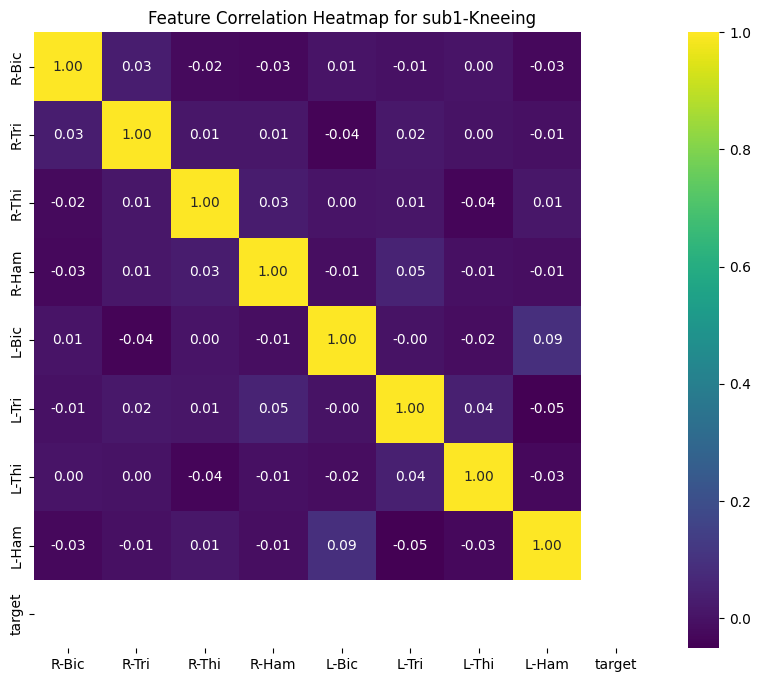

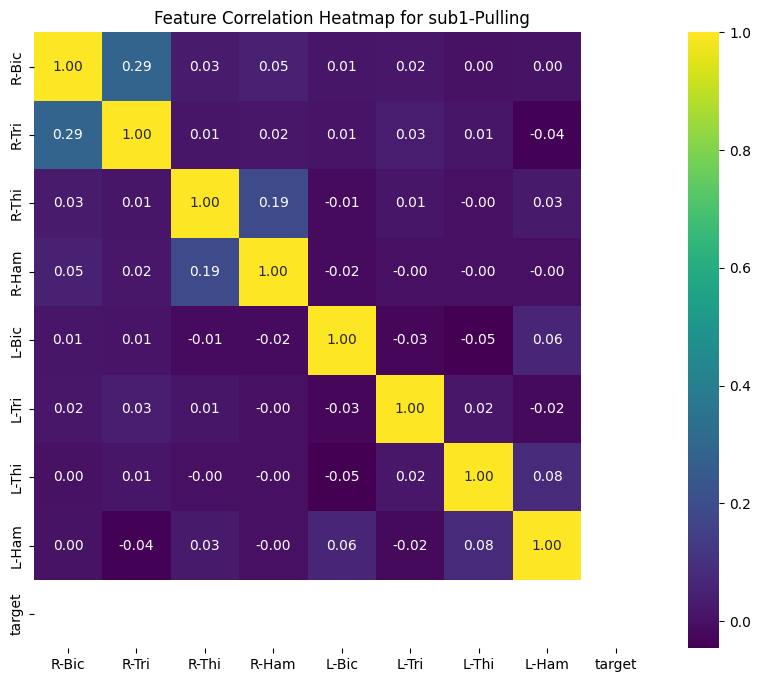

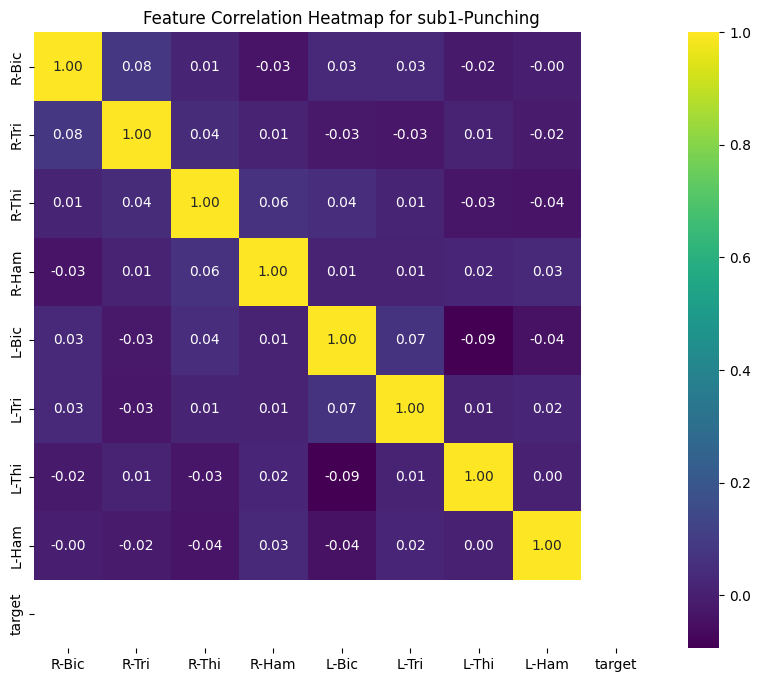

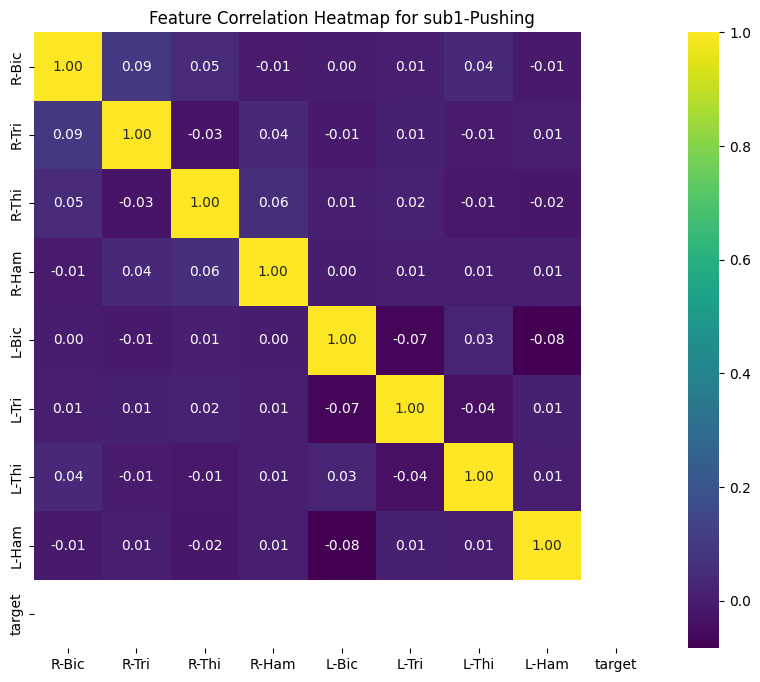

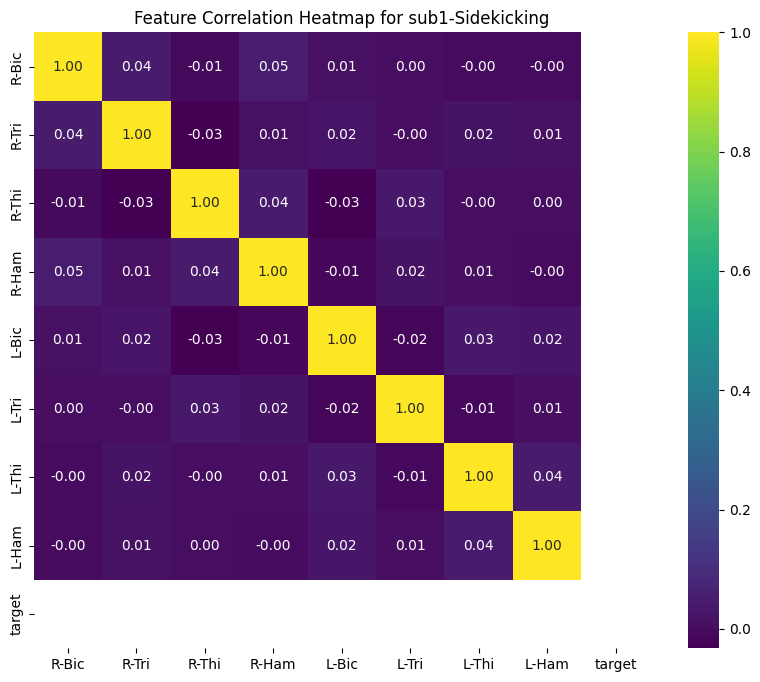

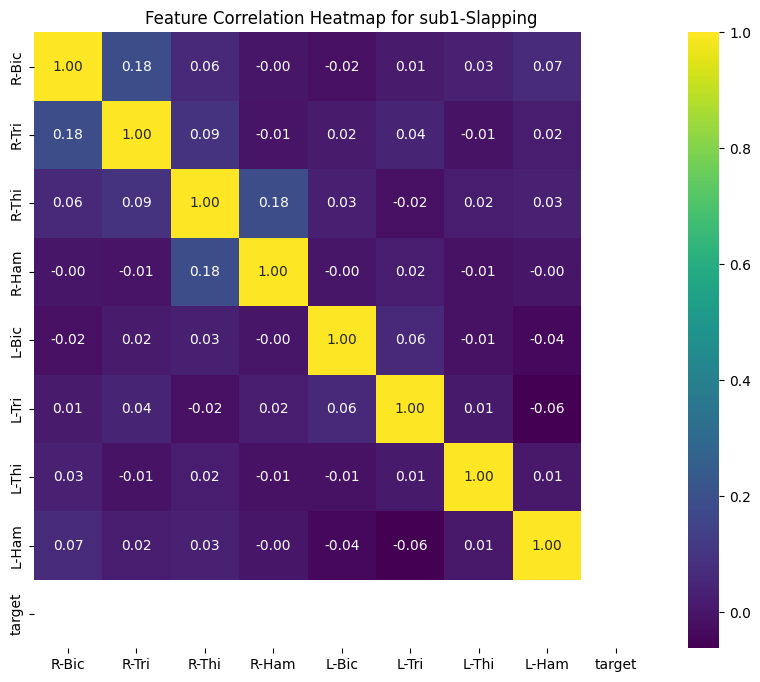

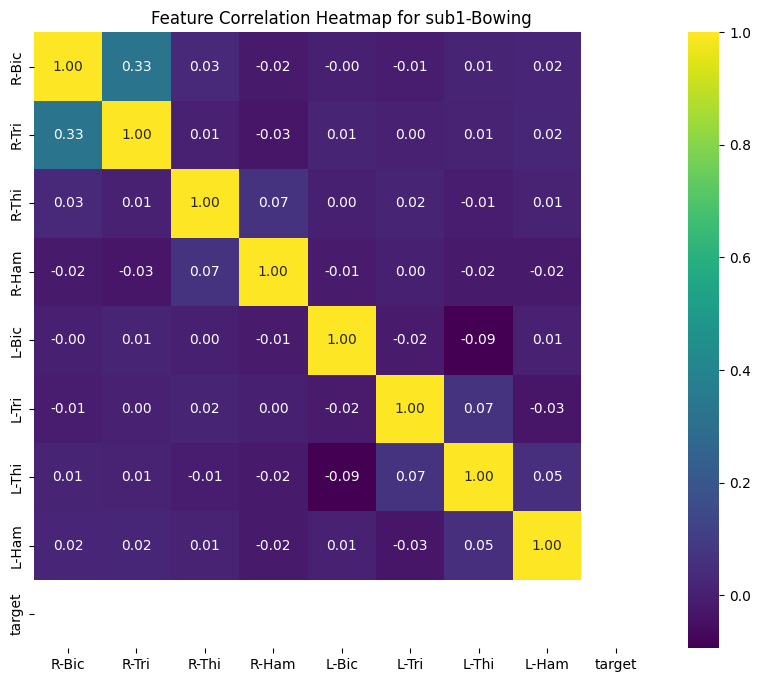

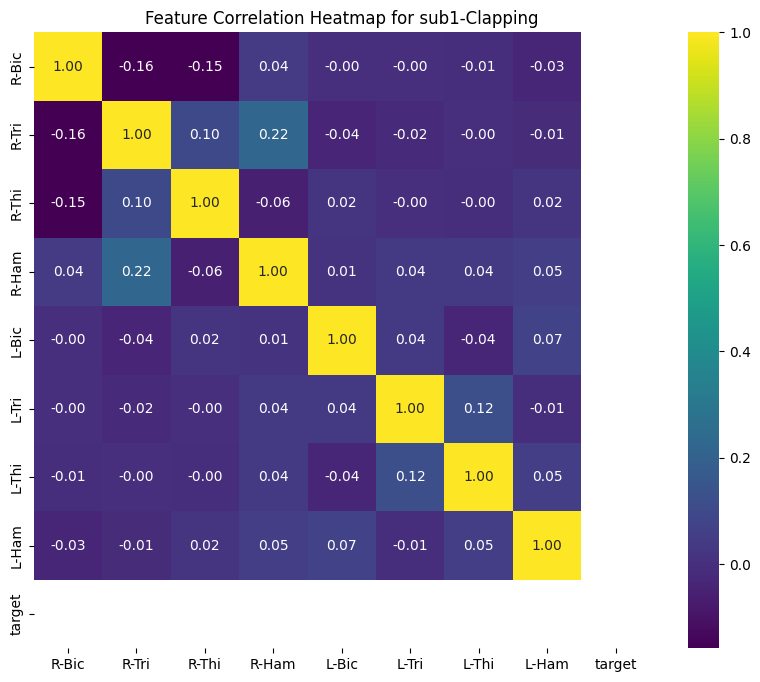

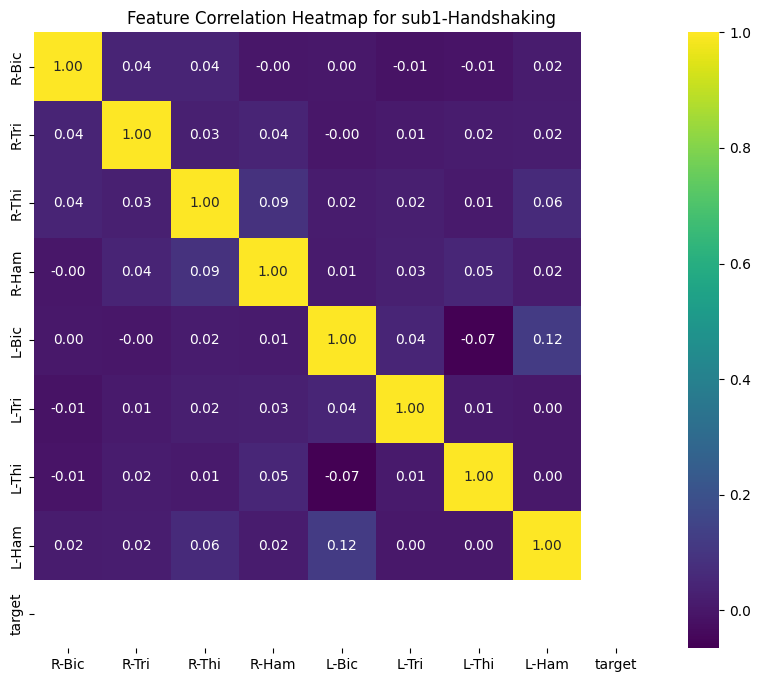

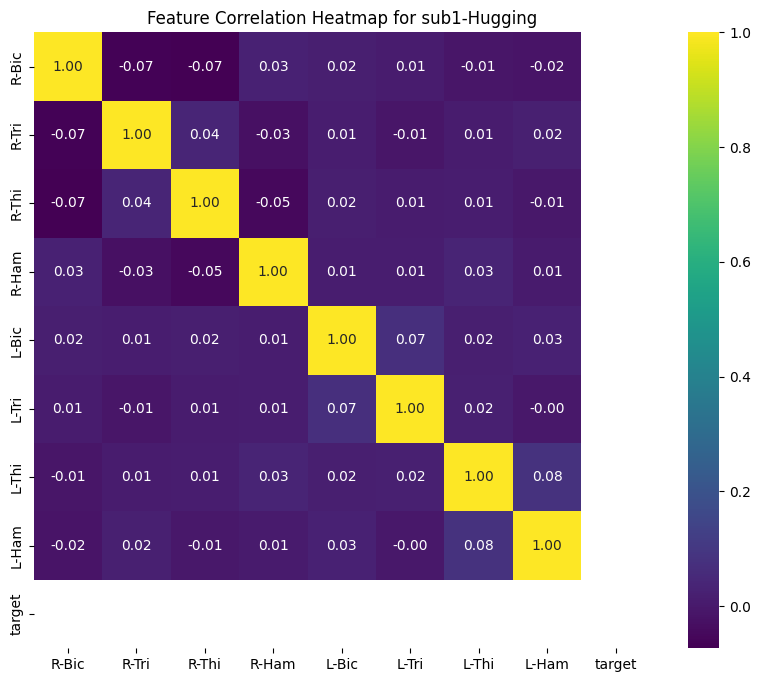

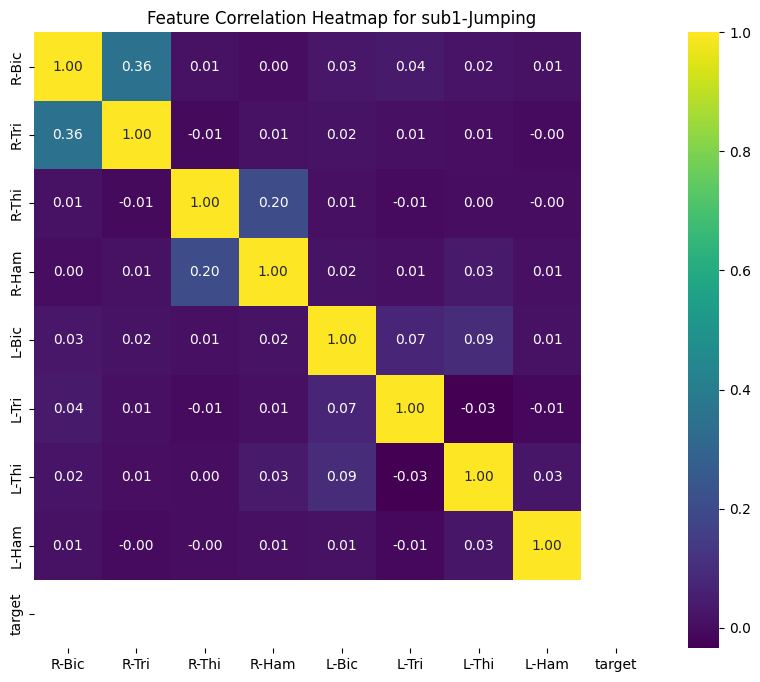

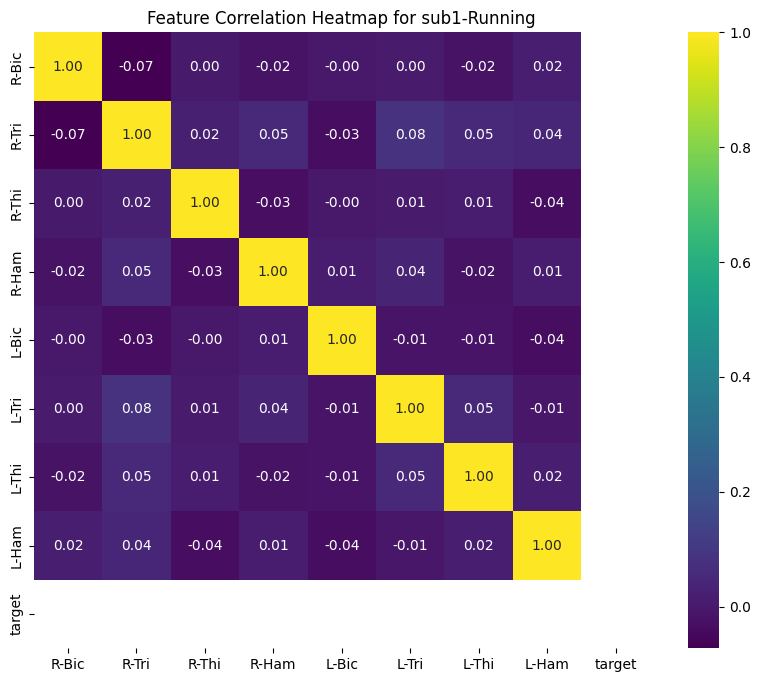

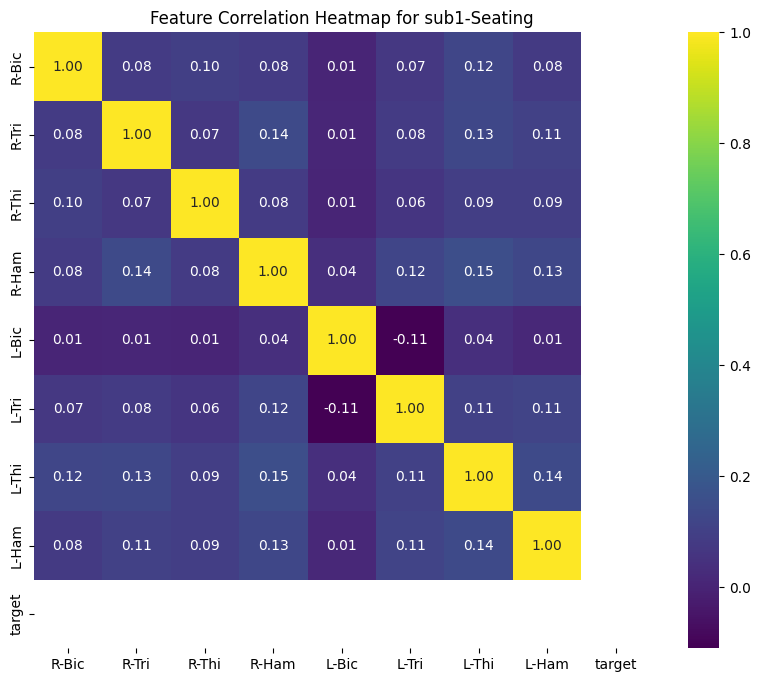

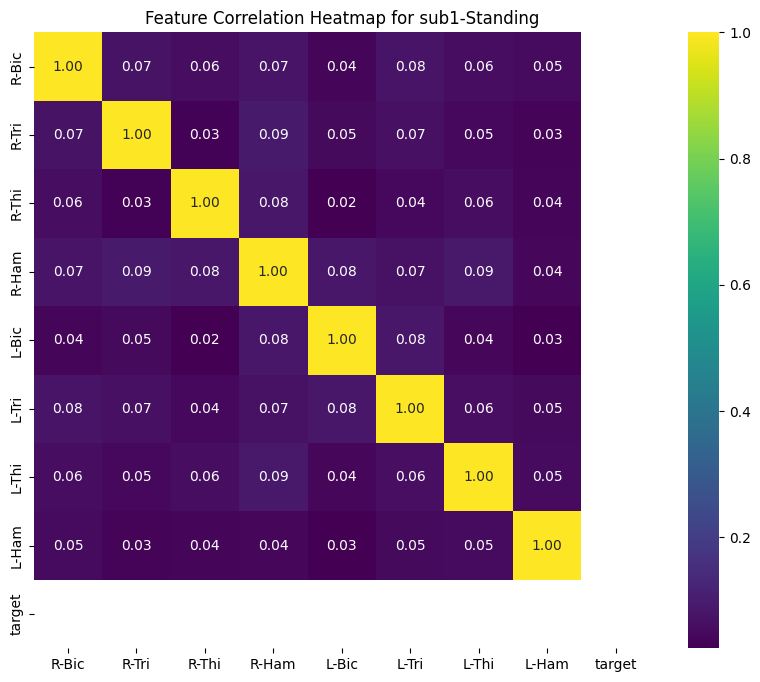

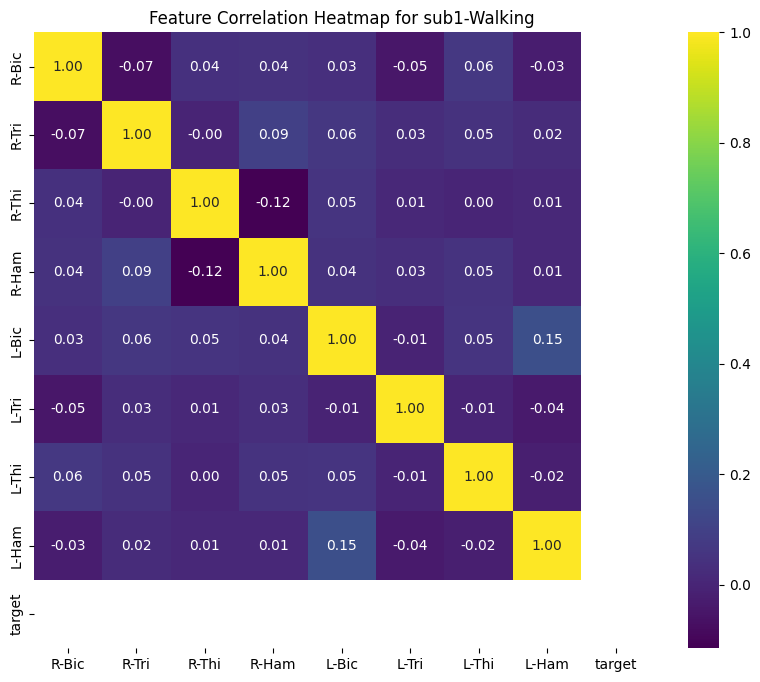

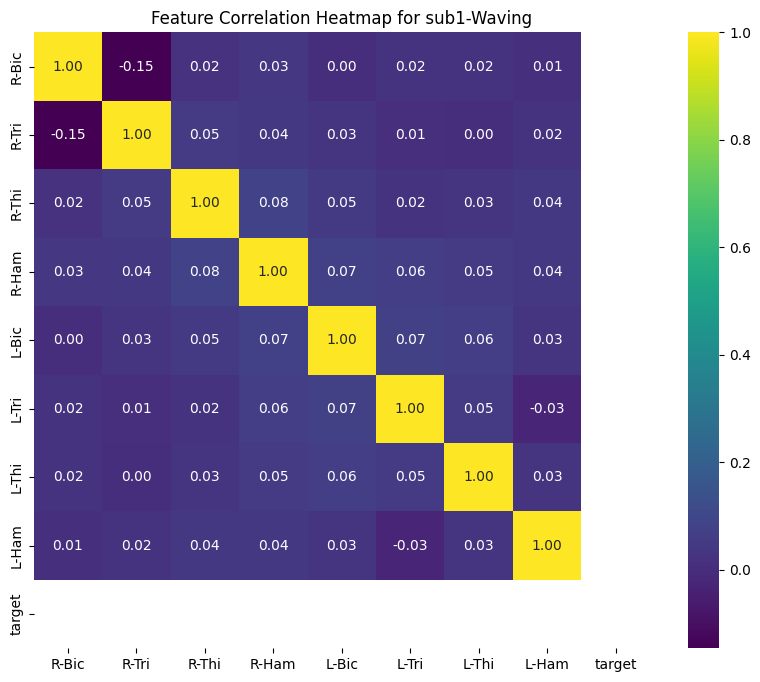

In [125]:
# heatmap 시각화

for key_2 in dir_df['sub1'].keys() : 
    df = dir_df['sub1'][key_2]
    corr_matrix = df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, 
                fmt='.2f', cmap='viridis', 
                cbar=True, square=True)

    plt.title(f'Feature Correlation Heatmap for sub1-{key_2}')
    
    plt.savefig(f'heatmap_{key_2}.jpg', format='jpg')
    plt.show()

위 heatmap을 보고 다음과 같은 내용을 생각해본다.

- **대게적으로 각 feature가 다른 feature와 상호작용하지 않고 있음을 나타내고 있는 지표이다. 매우 낮은 수치의 corr이다.**
- Bowing에서 R-Bic와 R-Tri 사이에서 0.33의 **그나마** 높은 상관관계를 보인다.
- 조금 신기한 것은 **Hamering**이다.
    - R-Bic와 R-Tri 간 -0.18의 음의 상관관계가 나타나고 있다.
    - 이는 망치질 동안 **길항 근수축**으로 인하여 나타난 수치라고 예상된다.
    - 다른 heatmap에서는 대부분 양의 상관관계를 띄었지만, 유독 **망치질 heatmap에서는 음수 상관계수도 관측된다.**
        - 복합적인 근육 활성화로 인하여 그런 것 같다.








-------

### CNN-LSTM modeling

- 논문에서 주장하고 있는 모델인 CNN-LSTM을 실제로 구현해본다.

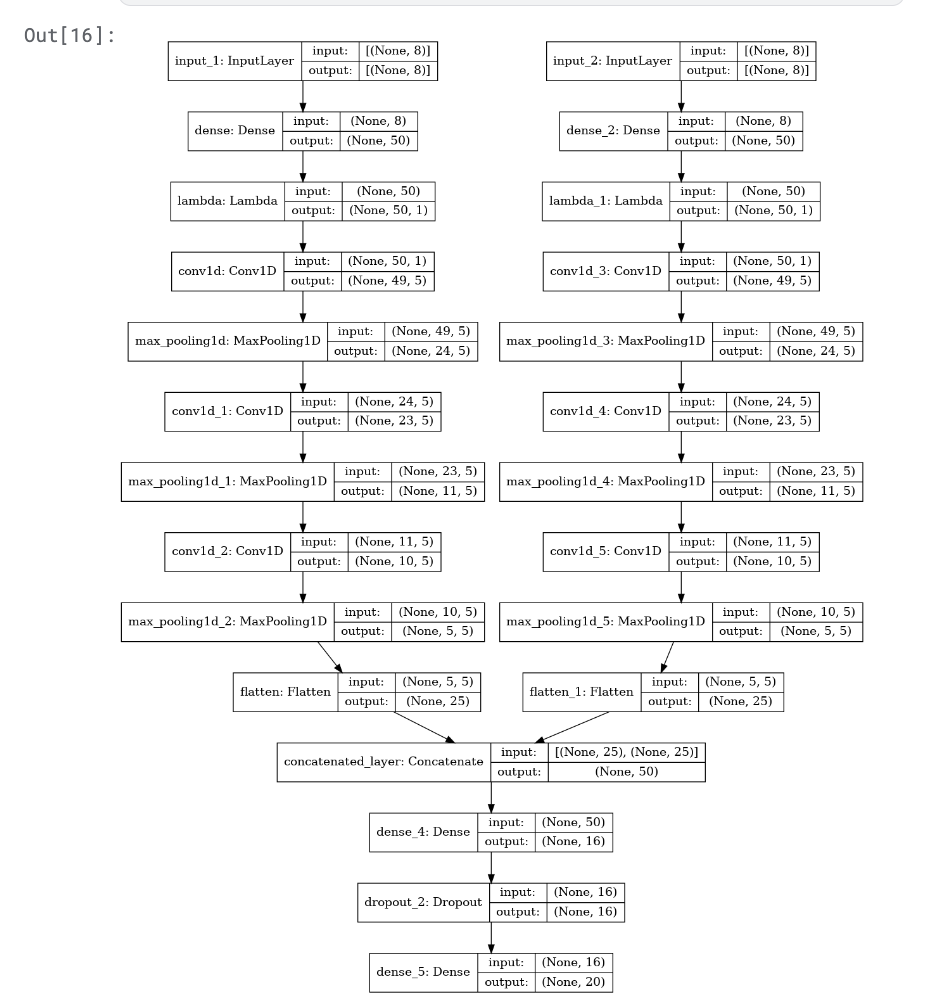

**https://www.kaggle.com/code/durgancegaur/emg-dataset/notebook** 에서 작성된 노트북 파일에서 아이디어를 얻었다. 위 figure에서 왼쪽 branch는 Normal set을 학습시키고, 오른쪽 branch는 Aggressive set을 학습시킨다. Concatenate 층에서 둘을 병합한 후 Dense를 이용하여 classification하는 구조이다.

나 또한 위 구조를 이용하여 각 set마다의 branch를 만들 것이며, 각각의 branch에 순환 신경망인 LSTM을 n개씩 배치하여 논문에서 주장하고 있는 바를 확인할 것이다.

In [126]:
# normal set, aggressive set prepare

normal_features = behaviors[0:10]
aggressive_features = behaviors[10:]

print ("normal_features : ", normal_features)
print ("aggressive_features : ", aggressive_features)

########

normal_set = pd.concat([dir_df['sub1'][key] for key in normal_features])
print (normal_set.info())
print (normal_set.shape)

aggressive_set = pd.concat([dir_df['sub1'][key] for key in aggressive_features])
print (aggressive_set.info())
print (aggressive_set.shape)

normal_features :  ['Elbowing', 'Frontkicking', 'Hamering', 'Headering', 'Kneeing', 'Pulling', 'Punching', 'Pushing', 'Sidekicking', 'Slapping']
aggressive_features :  ['Bowing', 'Clapping', 'Handshaking', 'Hugging', 'Jumping', 'Running', 'Seating', 'Standing', 'Walking', 'Waving']
<class 'pandas.core.frame.DataFrame'>
Index: 98172 entries, 0 to 9787
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   R-Bic   98172 non-null  int64
 1   R-Tri   98172 non-null  int64
 2   R-Thi   98172 non-null  int64
 3   R-Ham   98172 non-null  int64
 4   L-Bic   98172 non-null  int64
 5   L-Tri   98172 non-null  int64
 6   L-Thi   98172 non-null  int64
 7   L-Ham   98172 non-null  int64
 8   target  98172 non-null  int64
dtypes: int64(9)
memory usage: 7.5 MB
None
(98172, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 98886 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0  

In [127]:
# input, target split

normal_input = normal_set.drop('target', axis=1)
normal_target = normal_set['target']
aggressive_input = aggressive_set.drop('target', axis=1)
aggressive_target = aggressive_set['target']

In [128]:
# train, test split

from sklearn.model_selection import train_test_split

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(normal_input,
                                                    normal_target,
                                                    test_size = 0.2)

X_train_aggressive, X_test_aggressive, y_train_aggressive, y_test_aggressive = train_test_split(aggressive_input,
                                                            aggressive_target, test_size=0.2)

print (X_train_normal.shape, 
       X_test_normal.shape, 
       y_train_normal.shape, 
       y_test_normal.shape)

print (X_train_aggressive.shape, 
       X_test_aggressive.shape, 
       y_train_aggressive.shape, 
       y_test_aggressive.shape)

(78537, 8) (19635, 8) (78537,) (19635,)
(79108, 8) (19778, 8) (79108,) (19778,)


In [129]:
# def split_sequences(sequences, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequences)):
#     # find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the dataset
# 		if end_ix > len(sequences):
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return np.array(X), np.array(y)

In [130]:
# # sequence data로 만들기

# train_set_normal = np.c_[X_train_normal, 
#                          y_train_normal]
# test_set_normal = np.c_[X_test_normal, 
#                         y_test_normal]
# train_set_aggressive = np.c_[X_train_aggressive, 
#                              y_train_aggressive]
# test_set_aggressive = np.c_[X_test_aggressive, 
#                             y_test_aggressive]

# X_train_normal, y_train_normal = split_sequences(train_set_normal, 60) 
# print(X_train_normal.shape, y_train_normal.shape)
# X_test_normal, y_test_normal = split_sequences(test_set_normal, 60)
# print(X_test_normal.shape, y_test_normal.shape)

# X_train_aggressive, y_train_aggressive = split_sequences(train_set_aggressive, 60) 
# print(X_train_aggressive.shape, y_train_aggressive.shape)
# X_test_aggressive, y_test_aggressive = split_sequences(test_set_aggressive, 60)
# print(X_test_aggressive.shape, y_test_aggressive.shape)

In [134]:
# reshape

timesteps = 60

def reshape_data(X, timesteps) :
    '''
        데이터를 (sample 수, timesteps, feature 수) 로 변환하는 함수
    '''
    
    X = X.to_numpy()
    
    num_samples = X.shape[0] // timesteps
    X = X[:num_samples * timesteps]
    X = X.reshape((num_samples, timesteps, X.shape[1]))
    
    return X

X_train_normal_reshaped = reshape_data(X_train_normal, timesteps)
X_train_aggressive_reshaped = reshape_data(X_train_aggressive, timesteps)
X_test_normal_reshaped = reshape_data(X_test_normal, timesteps)
X_test_aggressive_reshaped = reshape_data(X_test_aggressive, timesteps)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 60, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 60, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 59, 8)     │        136 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 59, 8)     │        136 │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 59, 8)     │          0 │ conv1d_36[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 59, 8)     │          0 │ conv1d_37[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 29, 8)     │          0 │ dropout_12[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 29, 8)     │          0 │ dropout_13[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │     70,144 │ max_pooling1d_33… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 128)       │     70,144 │ max_pooling1d_34… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 256)       │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     32,896 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 20)        │      2,580 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 176,036 (687.64 KB)

 Trainable params: 176,036 (687.64 KB)

 Non-trainable params: 0 (0.00 B)

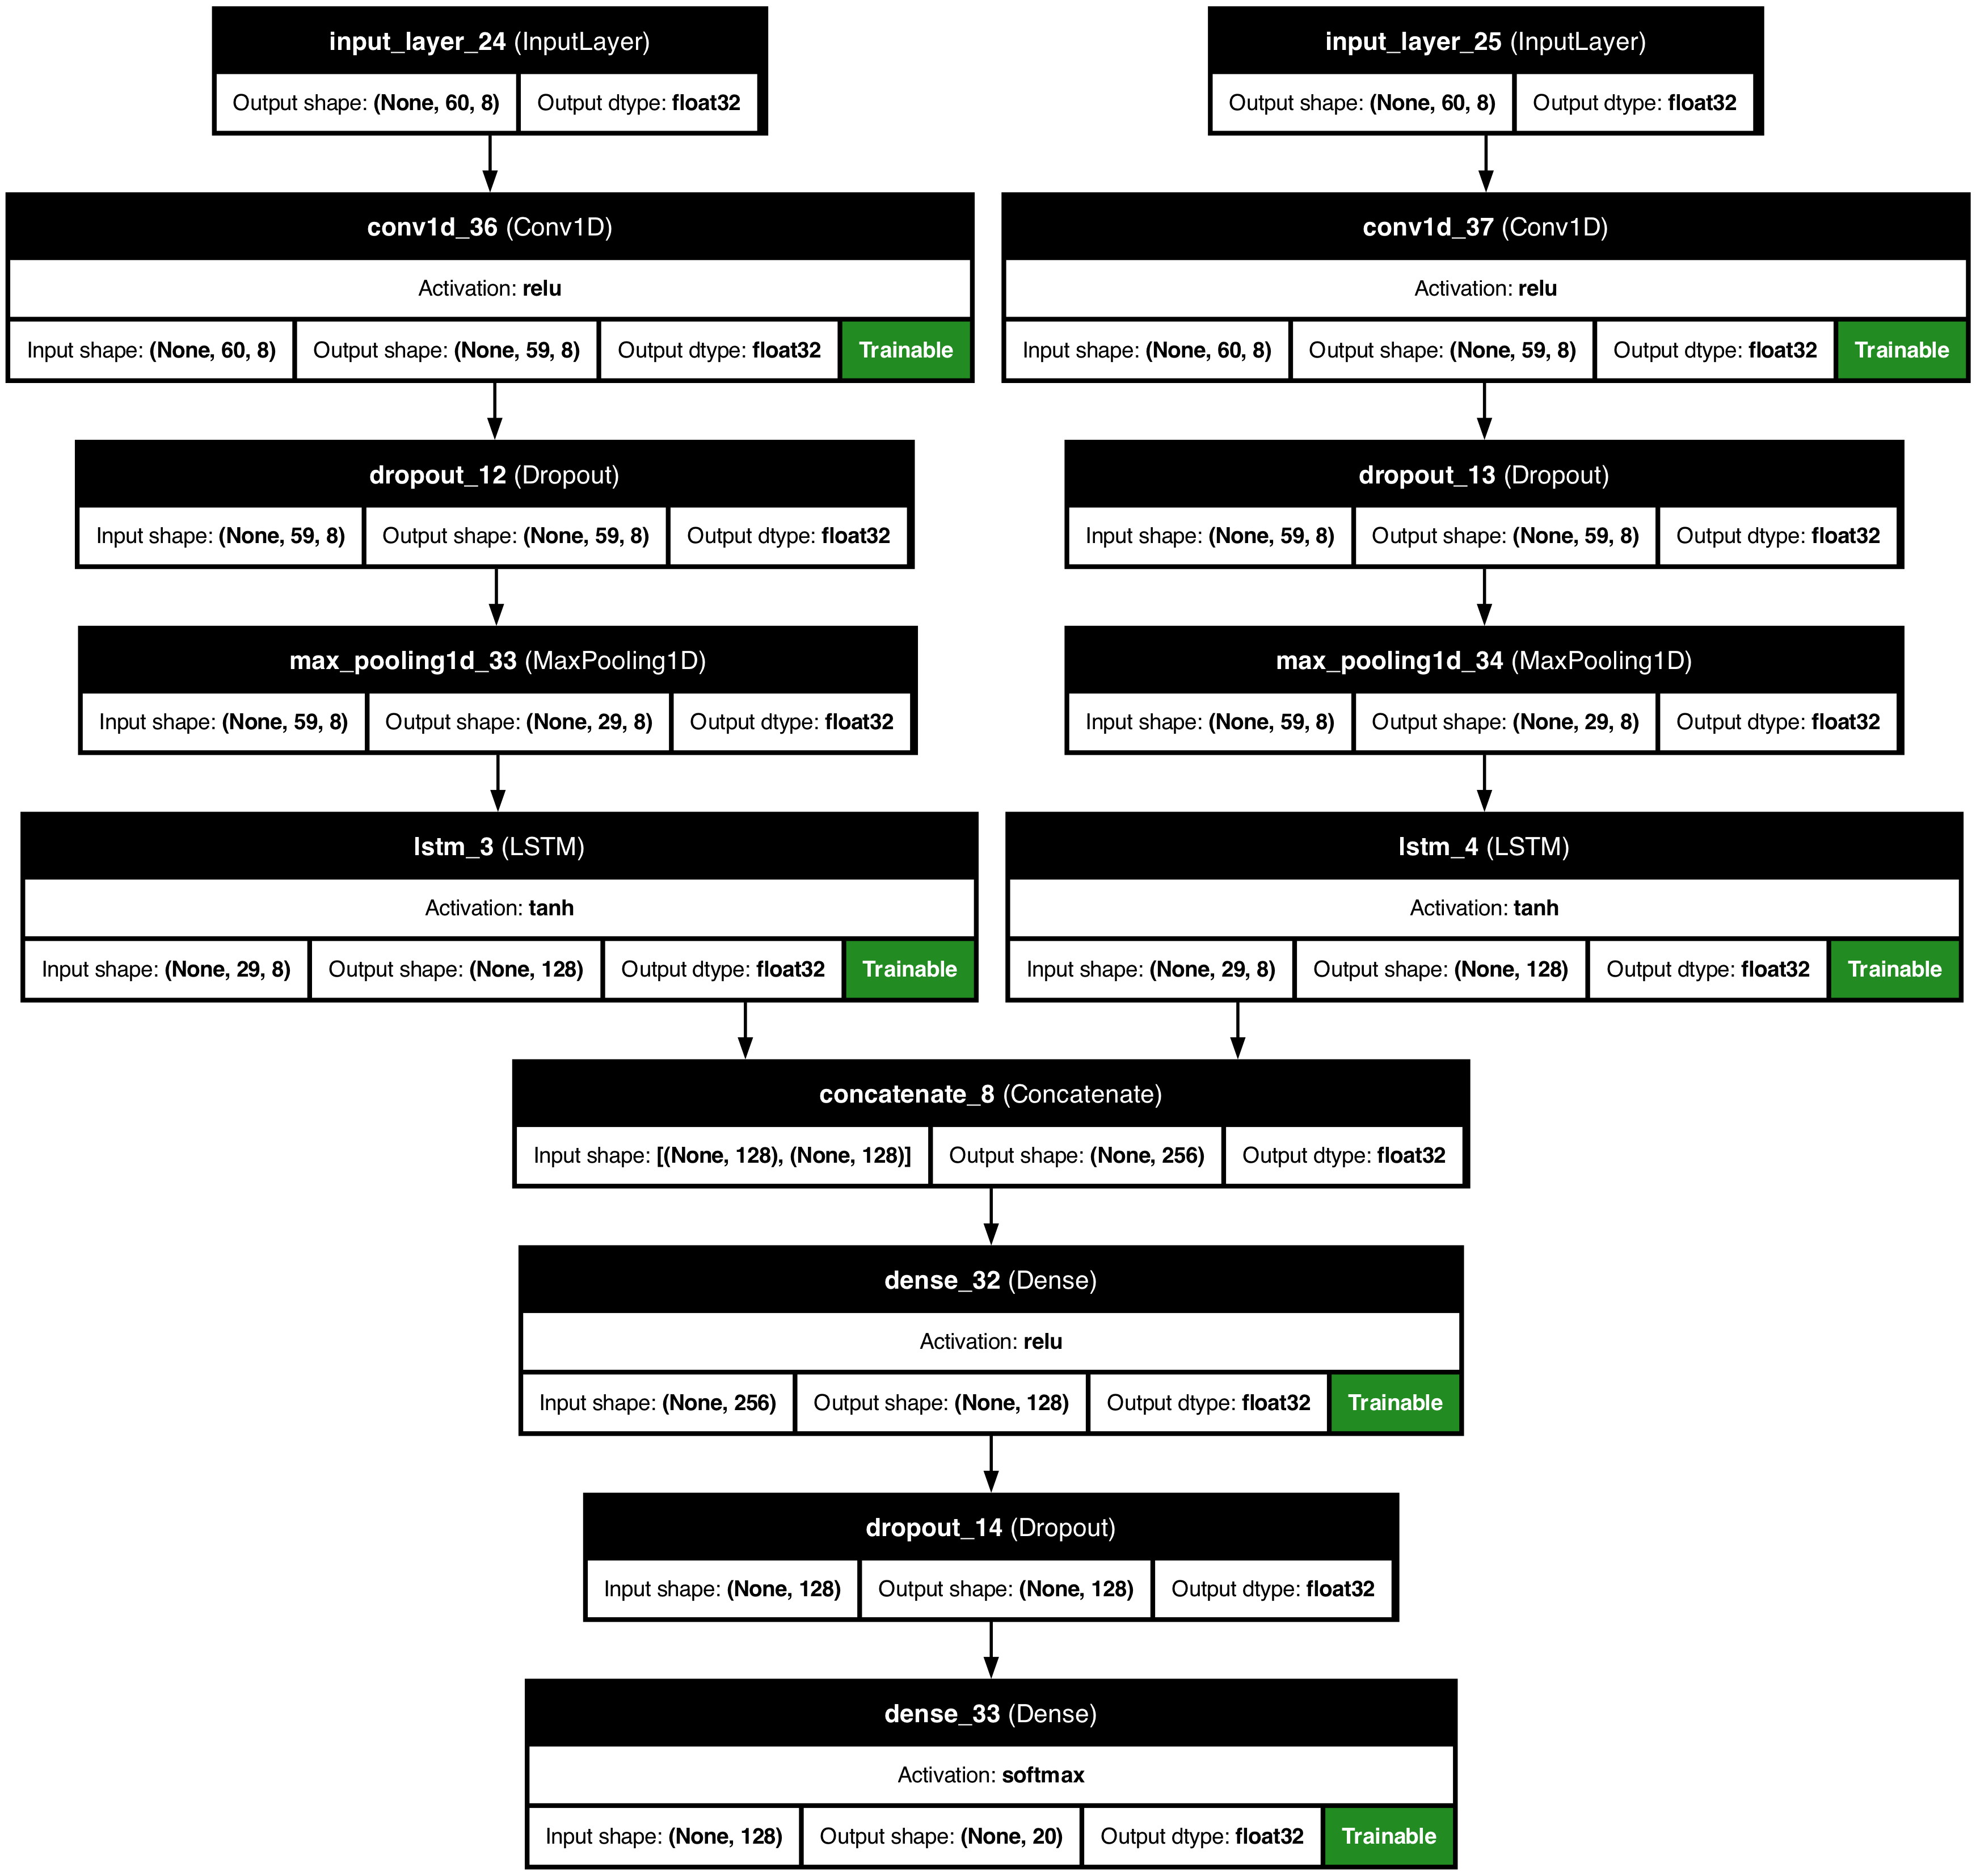

In [143]:
# modelling

from tensorflow.keras import layers, models
import tensorflow as tf

input_1 = layers.Input(shape=(X_train_normal_reshaped.shape[1], X_train_normal_reshaped.shape[2])) # normal dataset
input_2 = layers.Input(shape=(X_train_aggressive_reshaped.shape[1], X_train_aggressive_reshaped.shape[2])) # aggressive dataset

# branch 1
conv1_1 = layers.Conv1D(filters=8, kernel_size=2, activation='relu')(input_1)
dropout_1_1 = layers.Dropout(0.1)(conv1_1)
max_pool_1_1 = layers.MaxPooling1D(pool_size=2)(dropout_1_1)

# branch 2
conv2_1 = layers.Conv1D(filters=8, kernel_size=2, activation='relu')(input_2)
dropout_2_1 = layers.Dropout(0.1)(conv2_1)
max_pool_2_1 = layers.MaxPooling1D(pool_size=2)(dropout_2_1)

# LSTM
lstm_1 = layers.LSTM(128, return_sequences=False)(max_pool_1_1)
lstm_2 = layers.LSTM(128, return_sequences=False)(max_pool_2_1)

# 레이어 병합하기
concatenated_layer = layers.Concatenate()([lstm_1, lstm_2])

dense_1 = layers.Dense(128, activation='relu')(concatenated_layer)
dropout_3 = layers.Dropout(0.1)(dense_1)
output = layers.Dense(20, activation='softmax')(dropout_3)

model = models.Model(inputs=[input_1, input_2], outputs=output)

model.summary()

tf.keras.utils.plot_model(model,
                       show_dtype=True,
                       show_layer_activations=True,
                       show_layer_names=True,
                       show_shapes=True,
                       show_trainable=True)


In [144]:
# compile

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=adam, 
               loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'])

In [145]:
# fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                restore_best_weights=True)

from memory_profiler import profile

y_train = np.concatenate([y_train_normal, y_train_aggressive])

@profile # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model() :
    history = model.fit([X_train_normal_reshaped, 
                         X_train_aggressive_reshaped],
                        y_train, epochs=100, 
                        validation_split=0.1, 
                        callbacks=early_stopping_cb, 
                        verbose=True)
    
    return history
    
history = train_model()
print (history)

ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_32323/941010256.py
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.0501 - loss: 2.9075 - val_accuracy: 0.0687 - val_loss: 2.4922
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1273 - loss: 2.3750 - val_accuracy: 0.0840 - val_loss: 2.4070
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1303 - loss: 2.3077 - val_accuracy: 0.1145 - val_loss: 2.3715
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1703 - loss: 2.2482 - val_accuracy: 0.0840 - val_loss: 2.3587
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1724 - loss: 2.2485 - val_accuracy: 0.0992 - val_loss: 2.3733
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2124 - loss: 2.1944 - val_accuracy: 0.0763 - val_loss: 2.3596
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2102 - loss: 2.1945 - val_accuracy: 0.0840 - val_loss: 2.4230

총 2가지 model을 만들어 실험하였고, 둘 다 **accuracy는 그리 좋지 않았다.**
- model 1 : split_sequence를 통하여 순환 데이터 생성 및 대입
- model 2 : DNN 자체를 reshape하여 model에 대입